# Inspection for GeneralA2C

New features to include:
- player info
- top 5 actions and their distributions

TODO:
- look at state trajectories, they should be a list of dictionaries {"spatial","player"}
- create wrapper functions for the state plotting if possible, otherwise do it from scratch
- print in a formatted way all player info
- in general might be interesting for some minigames to plot some player info together with either the critic value or the actor adavantages in a step-by-step way
- change the way in which we deal with decision map plotting (?)

In [1]:
import os
import sys
sys.path.insert(0, "../")
# Custom modules
from AC_modules.BatchedA2C import GeneralA2C
from SC_Utils.game_utils import FullObsProcesser
import AC_modules.Networks as net
# change this inspection plots
from SC_Utils.inspection_plots_v2 import *
from SC_Utils.A2C_inspection_v2 import *
from SC_Utils.train_v4 import init_game, inspection_test

import torch
import numpy as np
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Define map_name and PID - ALWAYS

game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[1]

PID = "JNPB"

# Online plotting of training curve

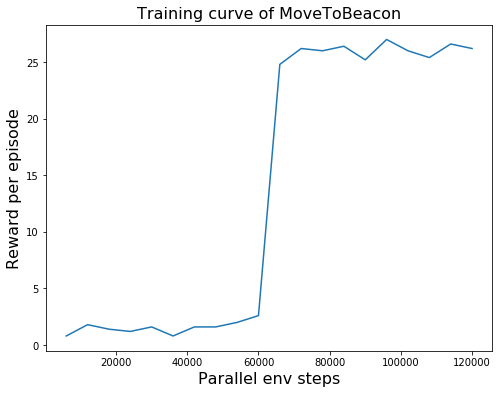

In [3]:
filename = '../Results/'+map_name+'/Logging/'+PID+'.txt'
logging = np.loadtxt(filename, delimiter=',', skiprows=1)
plot_logging(logging, map_name)

# Checkpoints at a certain step

In [4]:
jump = 6000 # number of env step after which an inspection is done
n = 20 # number of "jumps" to current step idx
step_idx =jump*n
step_idx

120000

In [5]:
load_dir = "../Results/"+map_name+"/Inspection/"
insp_dict = np.load(load_dir+PID+"_"+str(step_idx)+".npy", allow_pickle=True).item()

### Trajectory update

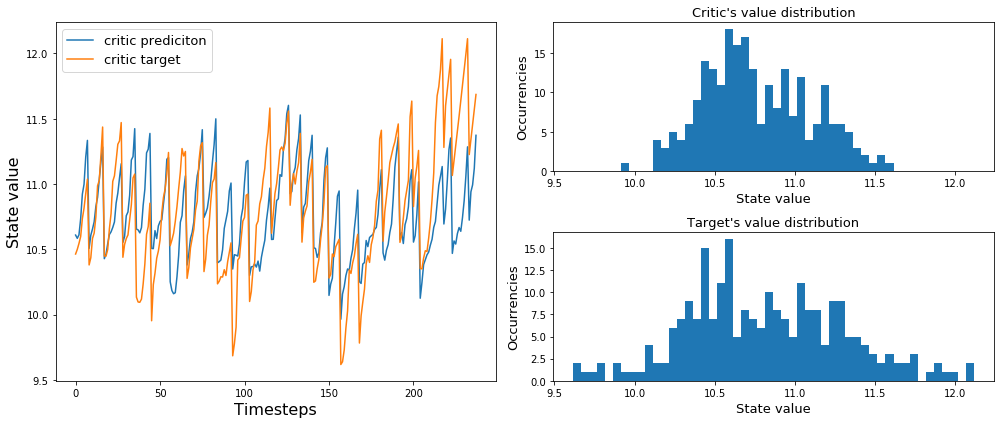

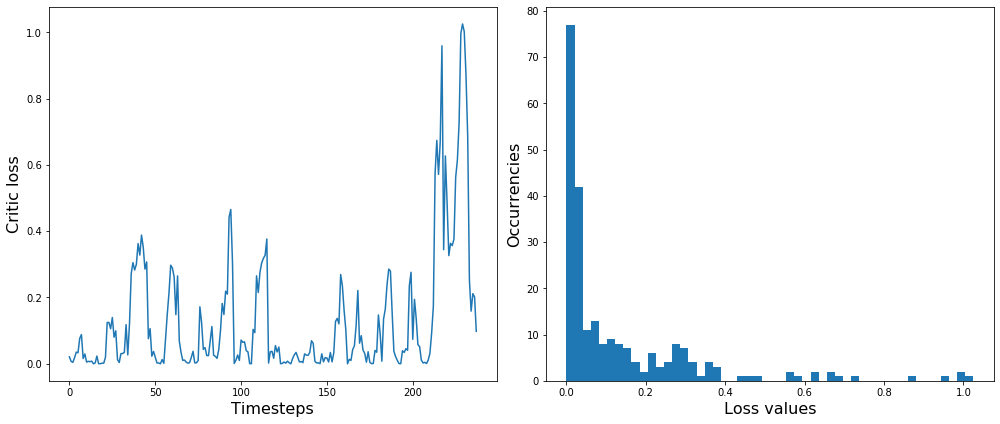

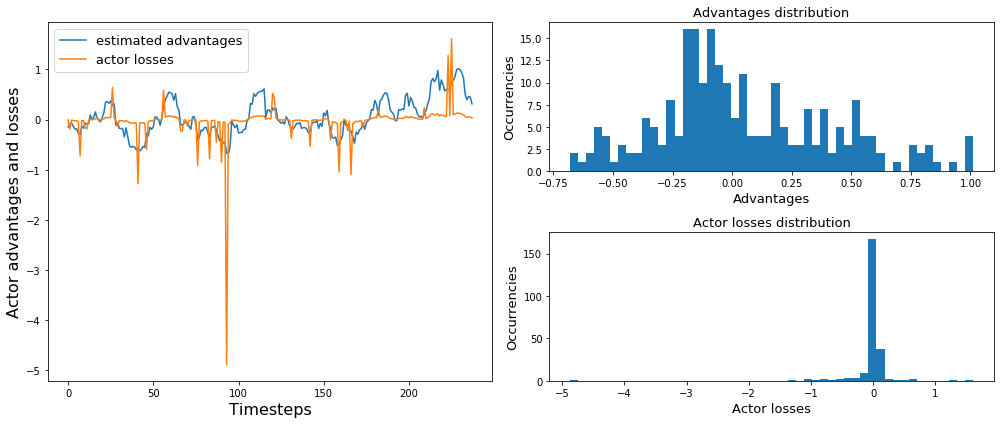

In [6]:
plot_update_curves(insp_dict)

## Agent-related visualizations

Here we need either to init a new agent and load a checkpoint or to load directly the full-trained agent if the training cycle is ended (automatic saving of the whole class if using the run.py script to train).

In [7]:
### Environment parameters ###
RESOLUTION = 32
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
env = init_game(game_params, map_name)

obs_proc_params = {'select_all':True}
op = FullObsProcesser(**obs_proc_params)

screen_channels, minimap_channels, in_player = op.get_n_channels()
in_channels = screen_channels + minimap_channels 

UnparsedFlagAccessError: Trying to access flag --sc2_run_config before flags were parsed.

In [20]:
load = False

if load:
    agent = torch.load("../Results/"+map_name+"/agent_"+PID, map_location='cpu')
    agent.device = 'cpu'
else:
    ### Agent architecture parameters ###
    spatial_model = net.FullyConvPlayerAndSpatial
    nonspatial_model = net.FullyConvNonSpatial
    # Internal features, passed inside a dictionary
    conv_channels = 32
    player_features = 16
    # Exposed features, passed outside of a dictionary
    n_channels = 48
    n_features = 256
    spatial_dict = {"in_channels":in_channels, 'in_player':in_player, 
                    'conv_channels':conv_channels, 'player_features':player_features}
    nonspatial_dict = {'resolution':RESOLUTION, 'kernel_size':3, 'stride':2, 'n_channels':n_channels}
    
    ### A2C parameters ###
    HPs = dict(gamma=0.99, n_steps=20, H=1e-2, 
               spatial_model=spatial_model, nonspatial_model=nonspatial_model,
               n_features=n_features, n_channels=n_channels, 
               spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict)

    if torch.cuda.is_available():
        HPs['device'] = 'cuda'
    else:
        HPs['device'] = 'cpu'

    print("Using device "+HPs['device'])

    lr = 7e-4
    
    # Agent init 
    agent = GeneralA2C(env=env, **HPs)
    # Load proper checkpoint here - not activated in case of load=True, but can be changed if needed
    agent.AC.load_state_dict(torch.load("../Results/"+map_name+"/Checkpoints/"+PID+"_"+str(step_idx), map_location='cpu'))

Using device cuda


In [21]:
# inspector needed for the plotting
inspector = inspection_test(step_idx, agent, env, PID, op, agent.AC.action_space)
insp_dict = inspector.dict

In [22]:
_, layer_names = op.get_state(env.reset())
layer_names

{'screen_names': array(['visibility_map_1', 'visibility_map_2', 'player_id_1',
        'player_id_2', 'player_id_16', 'player_relative_1',
        'player_relative_3', 'player_relative_4', 'unit_type_9',
        'unit_type_18', 'unit_type_20', 'unit_type_45', 'unit_type_48',
        'unit_type_105', 'unit_type_110', 'unit_type_317', 'unit_type_341',
        'unit_type_342', 'unit_type_1680', 'selected_1', 'unit_hit_points',
        'unit_hit_points_ratio', 'unit_density', 'unit_density_aa',
        'pathable_1', 'buildable_1'], dtype='<U21'),
 'minimap_names': array(['visibility_map_1', 'visibility_map_2', 'camera_1', 'player_id_1',
        'player_id_2', 'player_id_16', 'player_relative_1',
        'player_relative_3', 'player_relative_4', 'selected_1',
        'pathable_1', 'buildable_1'], dtype='<U17'),
 'player_names': array(['minerals', 'vespene', 'food_used', 'food_cap', 'food_army',
        'food_workers', 'idle_worker_count', 'army_count'], dtype='<U17')}


Step 0
Action select_army - prob : 0.941
Action no_op - prob : 0.037
Action select_point - prob : 0.010
Action select_control_group - prob : 0.007
Action select_rect - prob : 0.004
-----------------------------------
Action chosen:  select_army


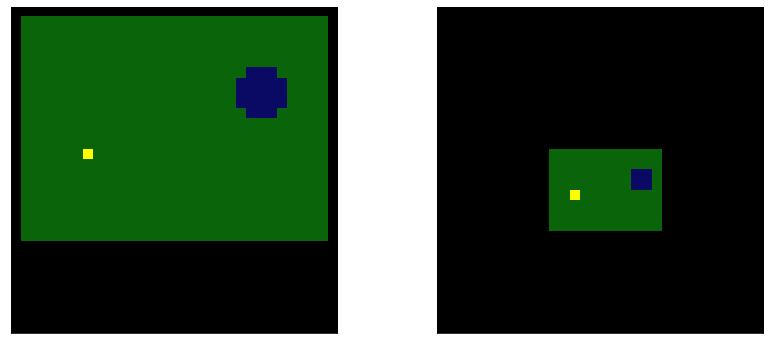

['select_army/select_add_distr']
[]
['select_point/select_point_act_distr', 'select_point/screen_distr']
['select_control_group/control_group_act_distr', 'select_control_group/control_group_id_distr']
['select_rect/select_add_distr', 'select_rect/screen_distr', 'select_rect/screen2_distr']


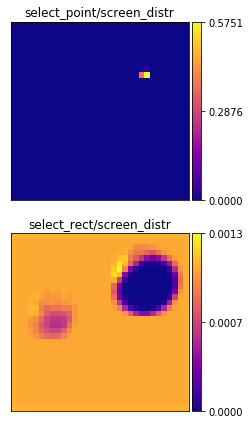


Step 1
Action Smart_screen - prob : 0.883
Action Attack_minimap - prob : 0.117
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


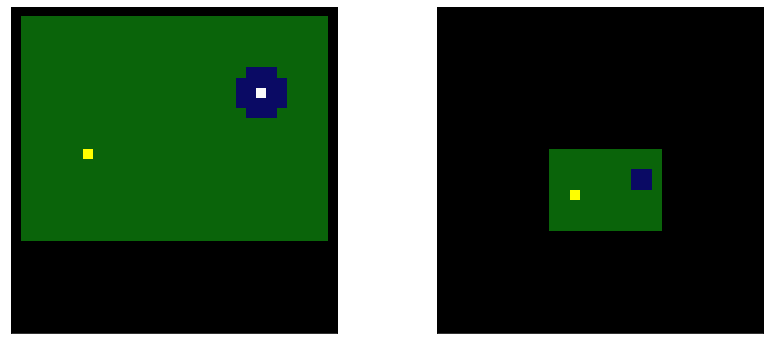

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


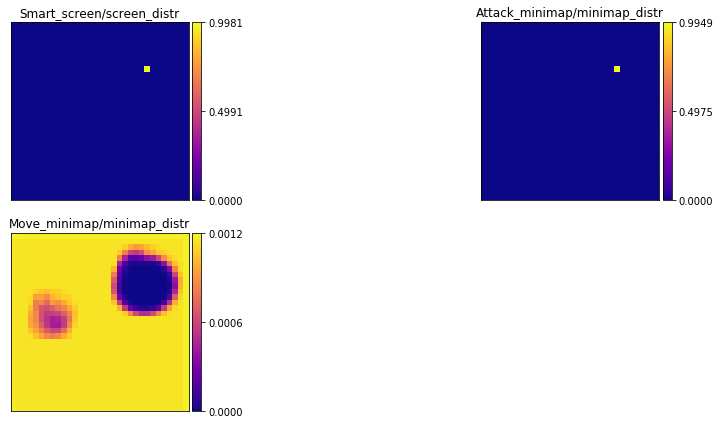


Step 2
Action Smart_screen - prob : 0.884
Action Attack_minimap - prob : 0.116
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


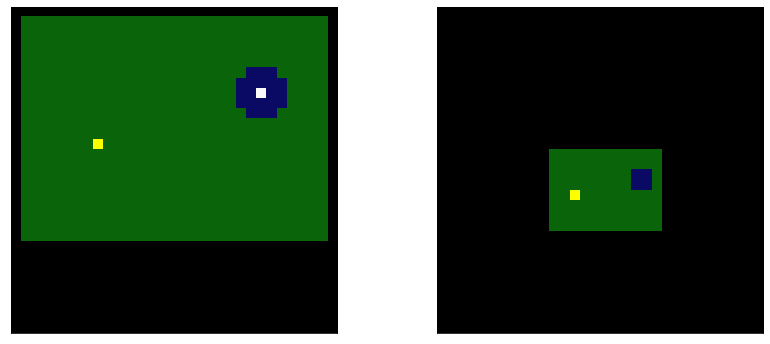

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


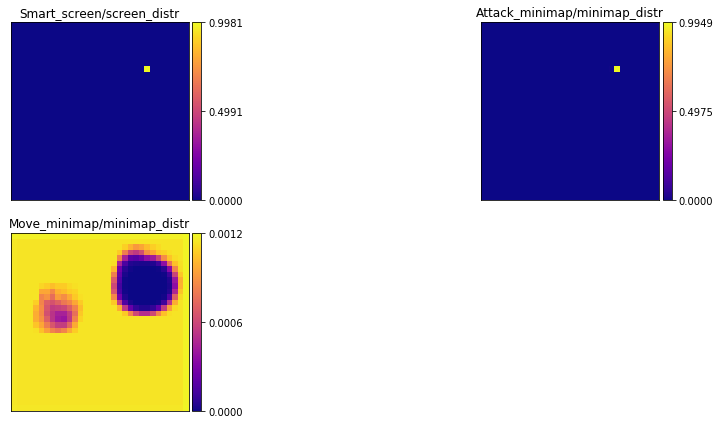


Step 3
Action Smart_screen - prob : 0.885
Action Attack_minimap - prob : 0.114
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


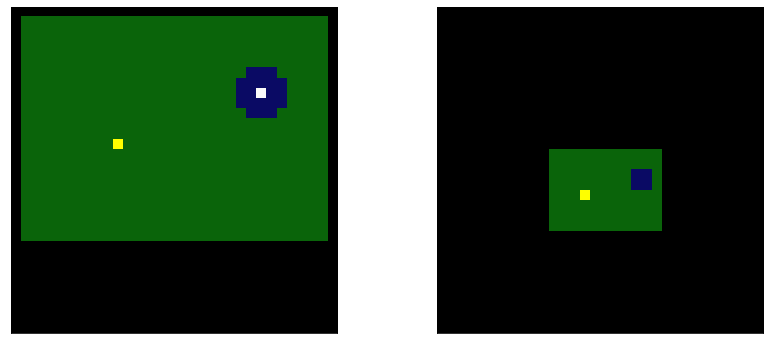

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


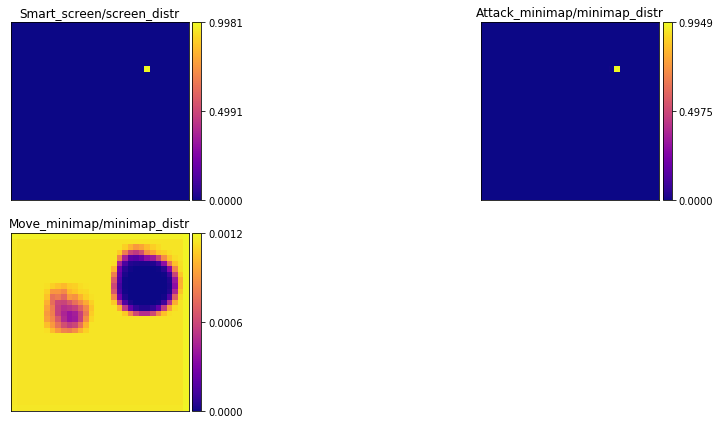


Step 4
Action Smart_screen - prob : 0.886
Action Attack_minimap - prob : 0.113
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Attack_minimap


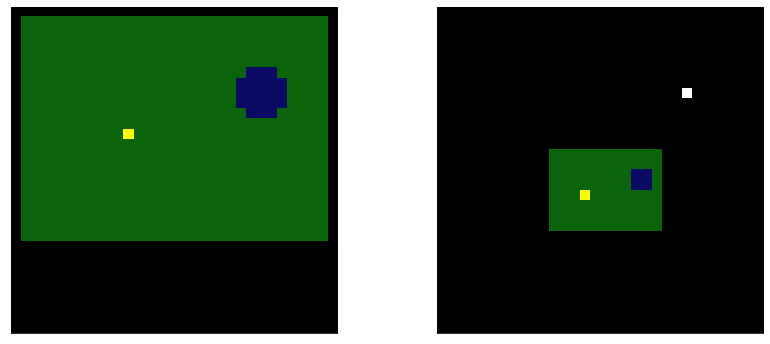

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


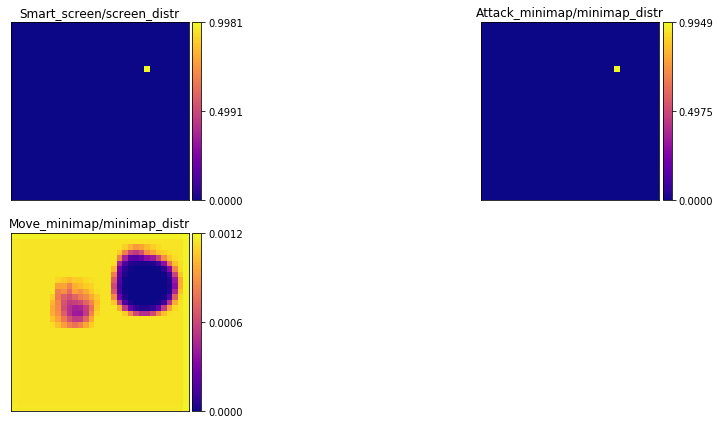


Step 5
Action Smart_screen - prob : 0.887
Action Attack_minimap - prob : 0.112
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


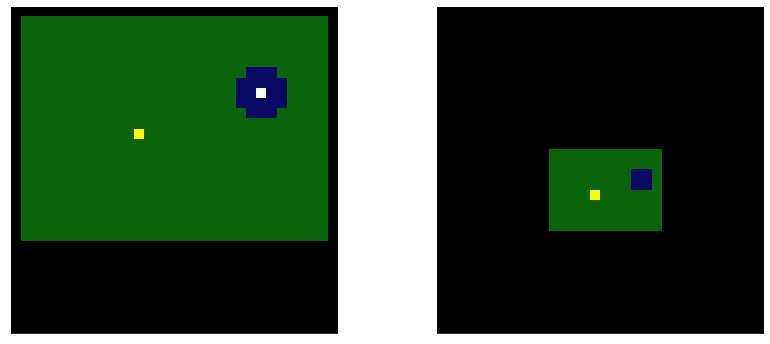

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


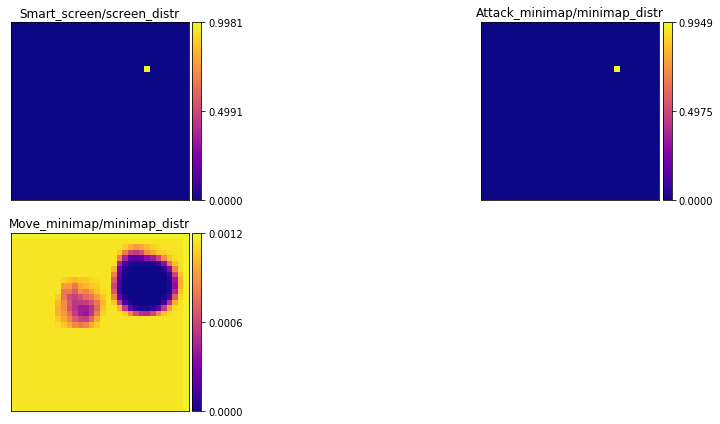


Step 6
Action Smart_screen - prob : 0.887
Action Attack_minimap - prob : 0.113
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


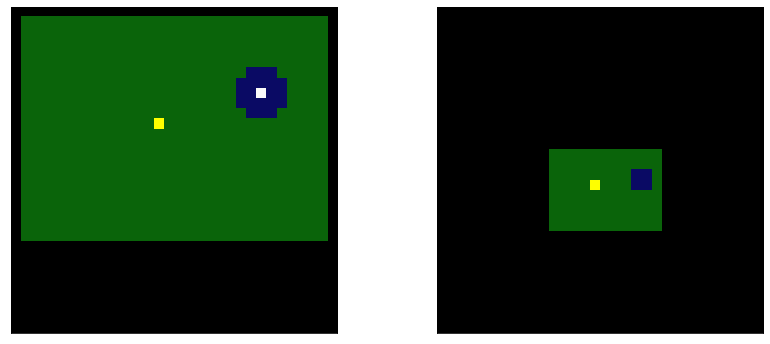

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


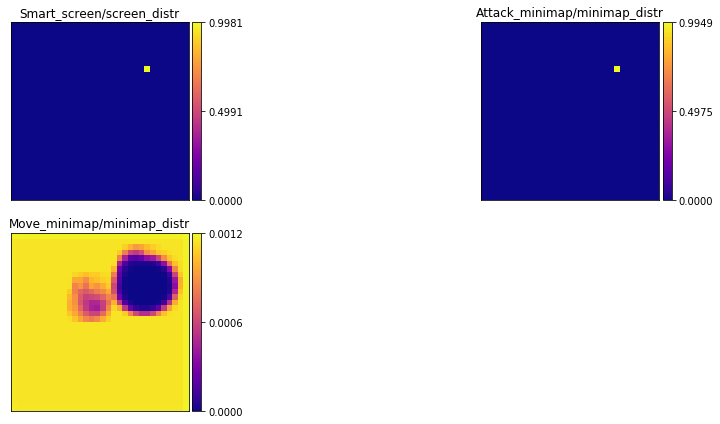


Step 7
Action Smart_screen - prob : 0.887
Action Attack_minimap - prob : 0.113
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


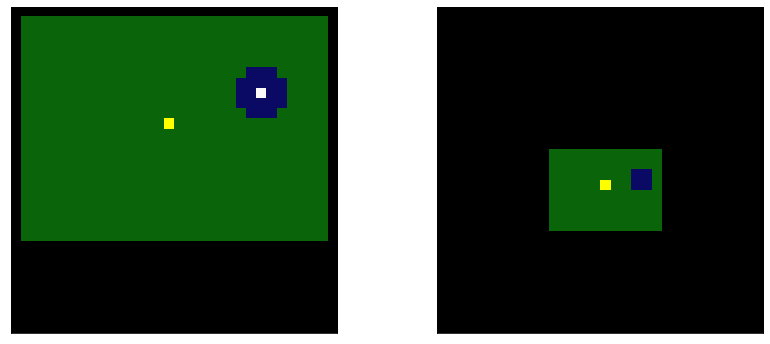

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


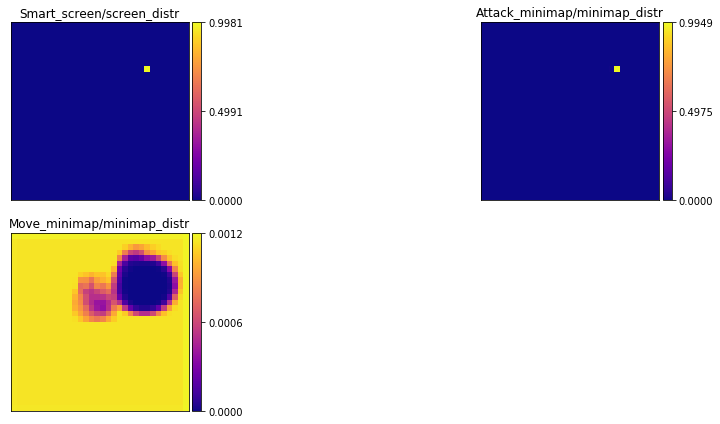


Step 8
Action Smart_screen - prob : 0.890
Action Attack_minimap - prob : 0.110
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


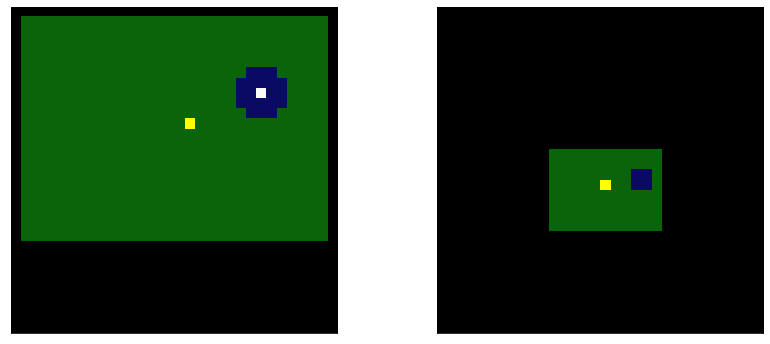

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


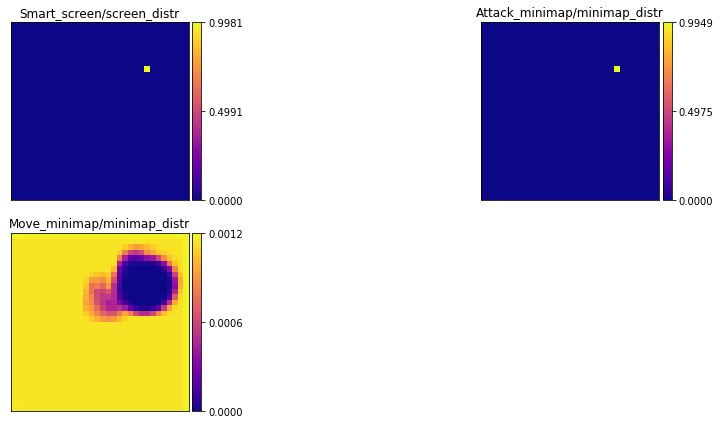


Step 9
Action Smart_screen - prob : 0.893
Action Attack_minimap - prob : 0.107
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


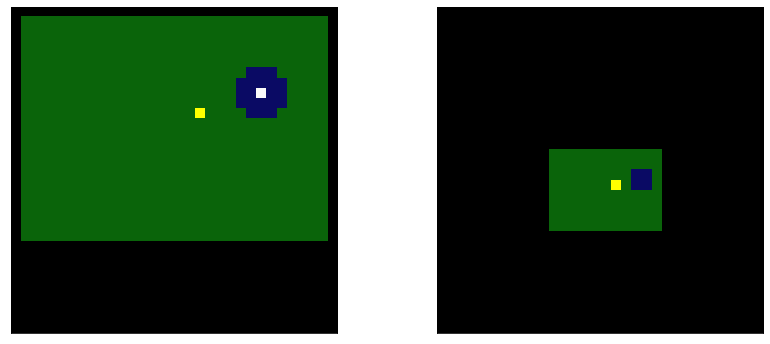

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


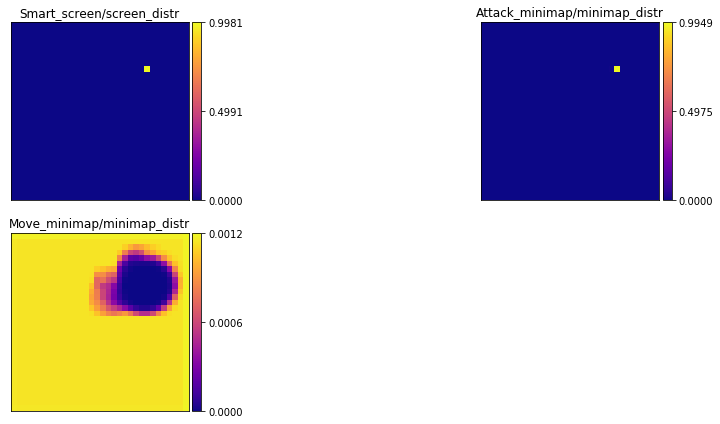


Step 10
Action Smart_screen - prob : 0.894
Action Attack_minimap - prob : 0.106
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


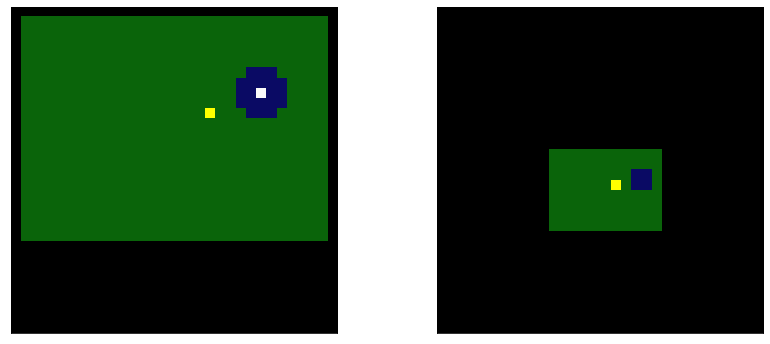

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


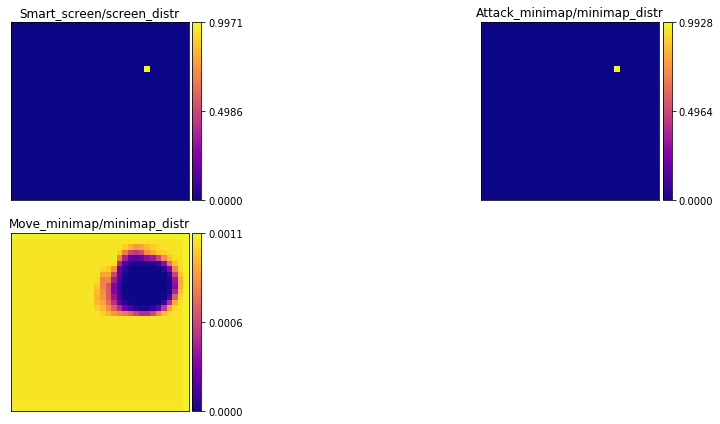


Step 11
Action Smart_screen - prob : 0.897
Action Attack_minimap - prob : 0.103
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


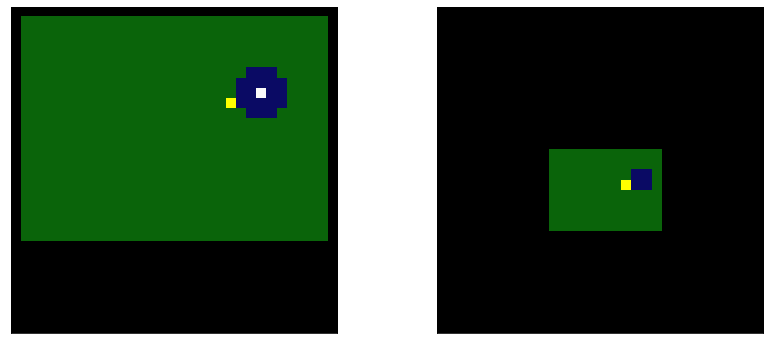

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


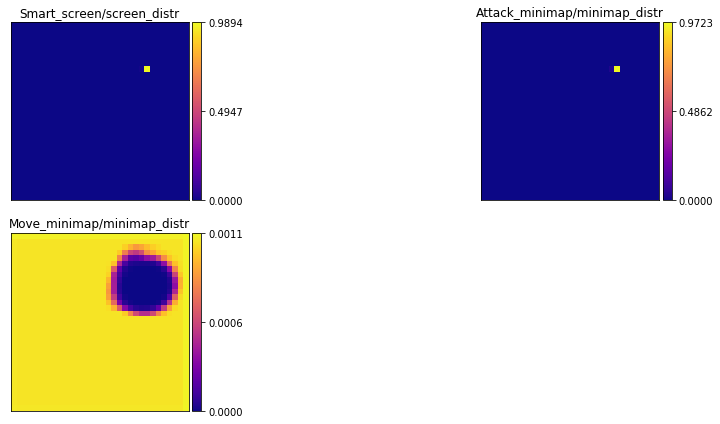


Step 12
Action Smart_screen - prob : 0.888
Action Attack_minimap - prob : 0.112
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


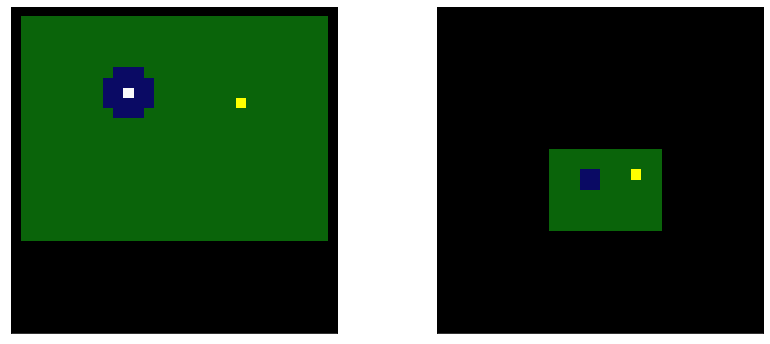

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


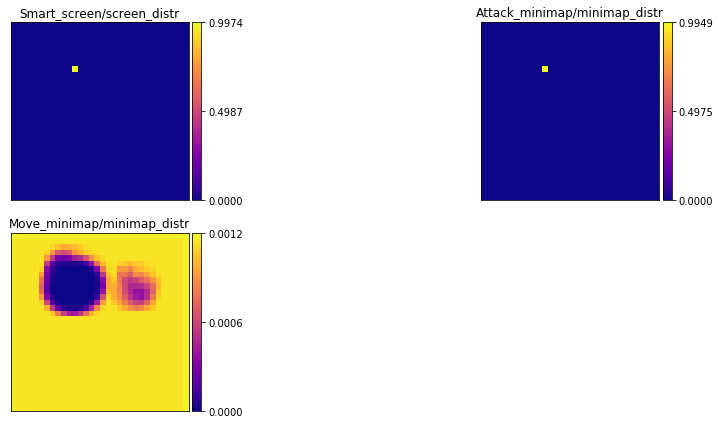


Step 13
Action Smart_screen - prob : 0.889
Action Attack_minimap - prob : 0.111
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


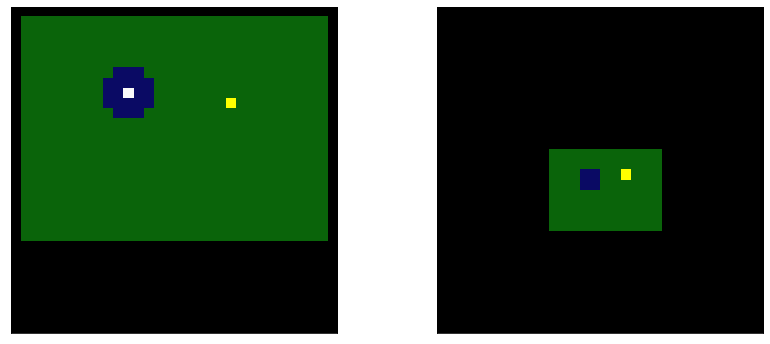

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


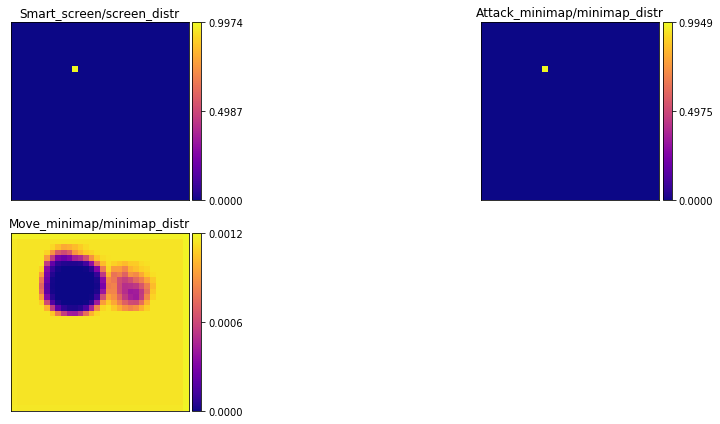


Step 14
Action Smart_screen - prob : 0.893
Action Attack_minimap - prob : 0.107
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


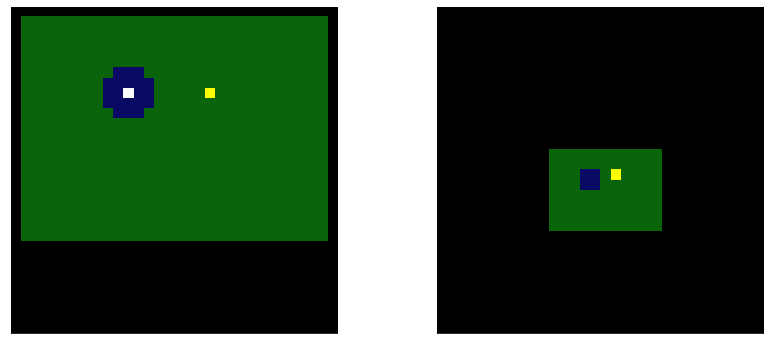

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


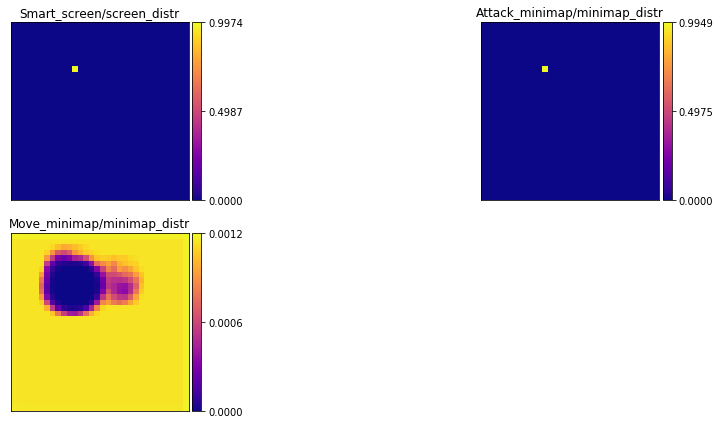


Step 15
Action Smart_screen - prob : 0.895
Action Attack_minimap - prob : 0.104
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


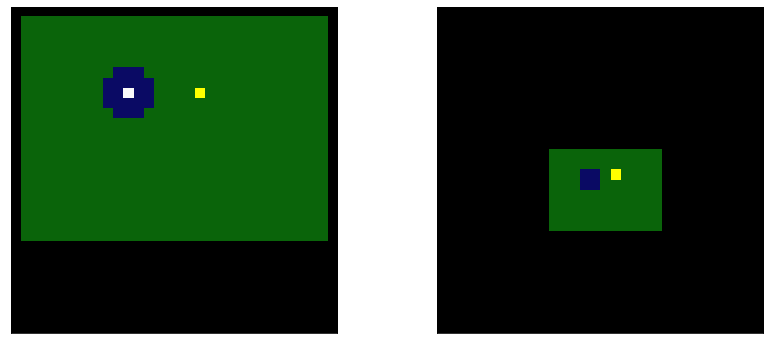

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


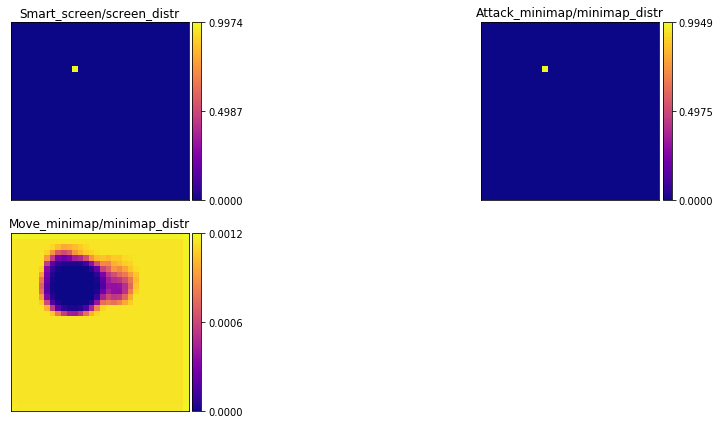


Step 16
Action Smart_screen - prob : 0.898
Action Attack_minimap - prob : 0.101
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


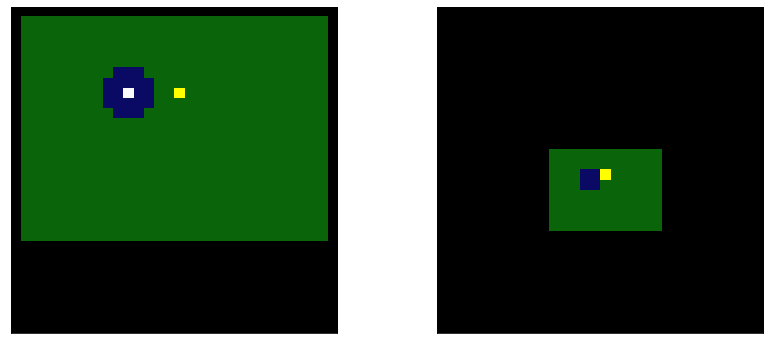

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


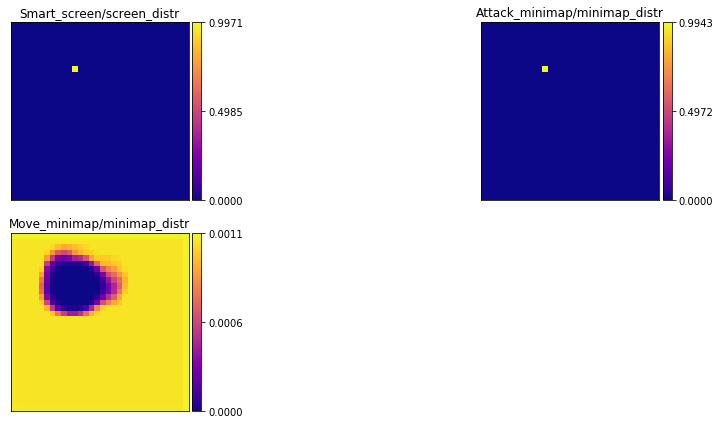


Step 17
Action Smart_screen - prob : 0.899
Action Attack_minimap - prob : 0.100
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


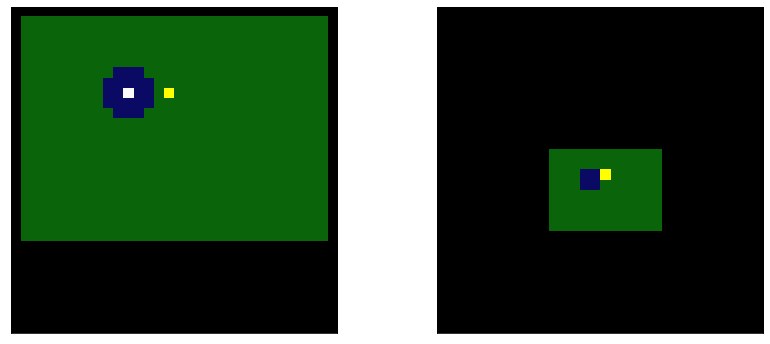

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


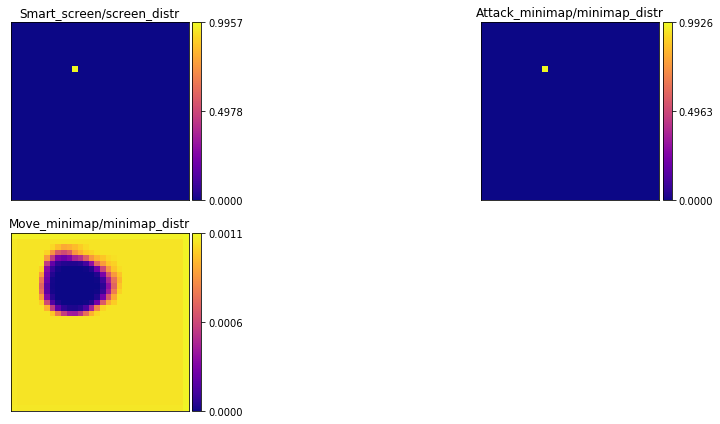


Step 18
Action Smart_screen - prob : 0.901
Action Attack_minimap - prob : 0.098
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


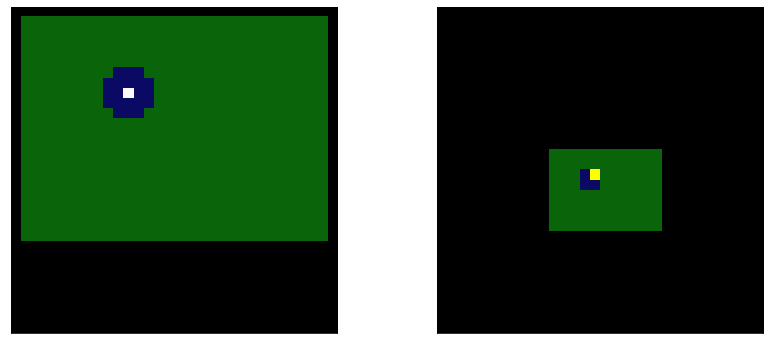

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


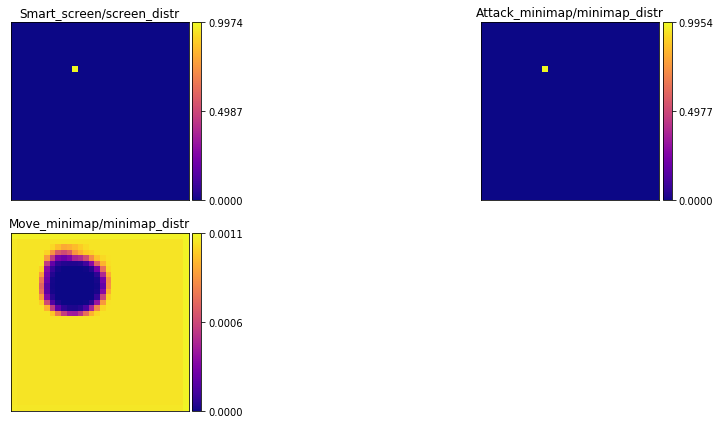


Step 19
Action Smart_screen - prob : 0.895
Action Attack_minimap - prob : 0.105
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


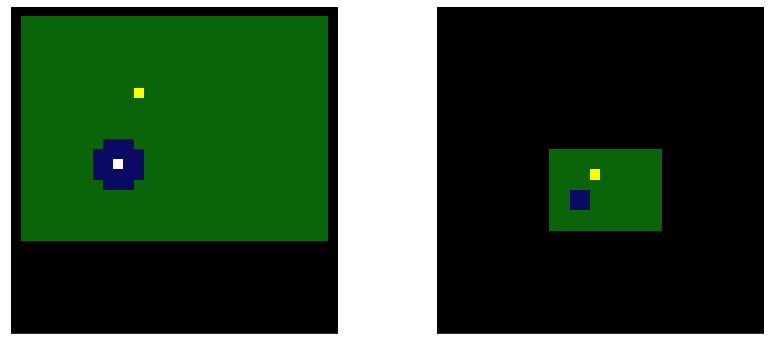

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


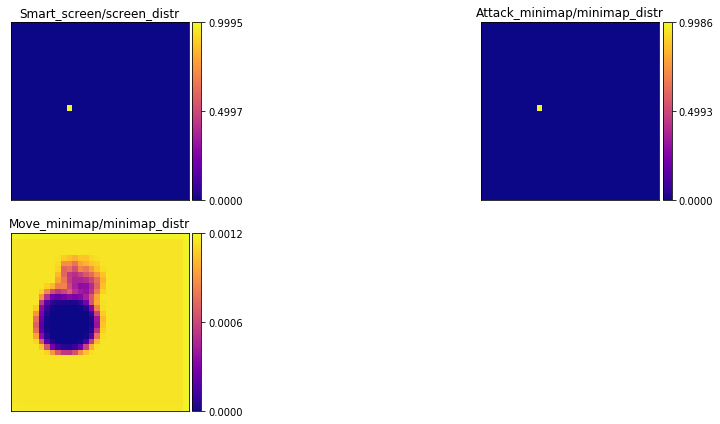


Step 20
Action Smart_screen - prob : 0.896
Action Attack_minimap - prob : 0.104
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Attack_minimap


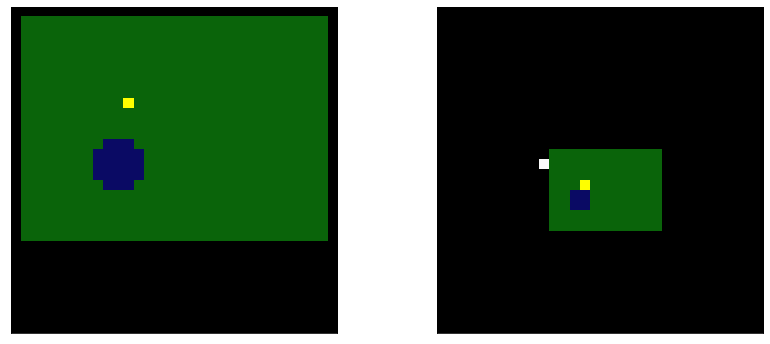

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


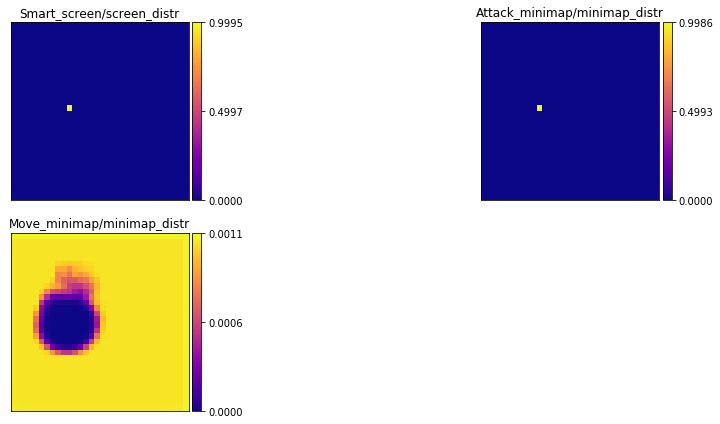


Step 21
Action Smart_screen - prob : 0.900
Action Attack_minimap - prob : 0.100
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


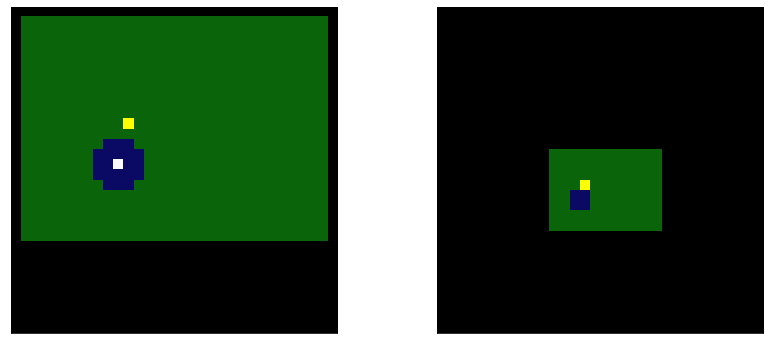

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


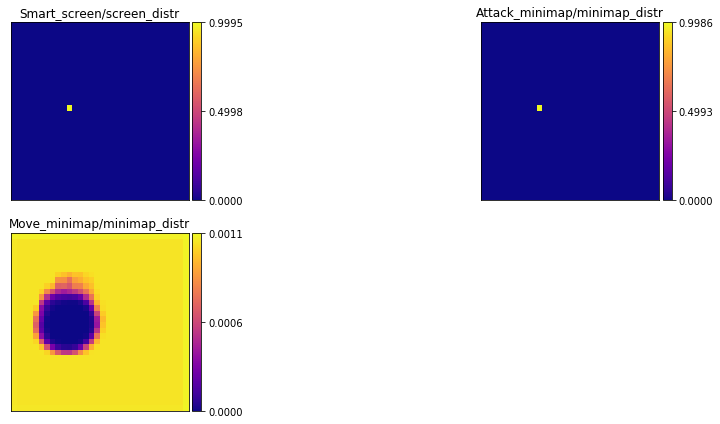


Step 22
Action Smart_screen - prob : 0.902
Action Attack_minimap - prob : 0.098
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


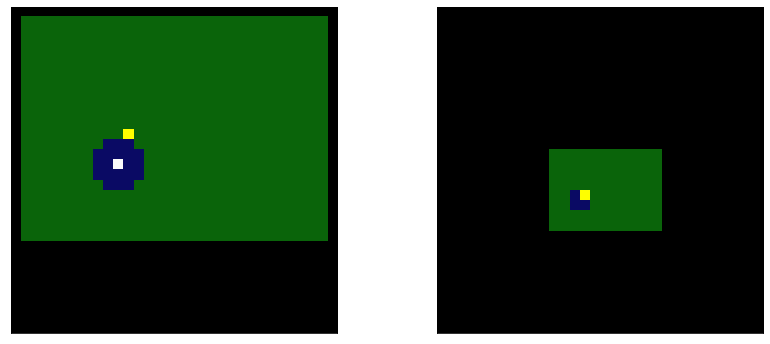

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


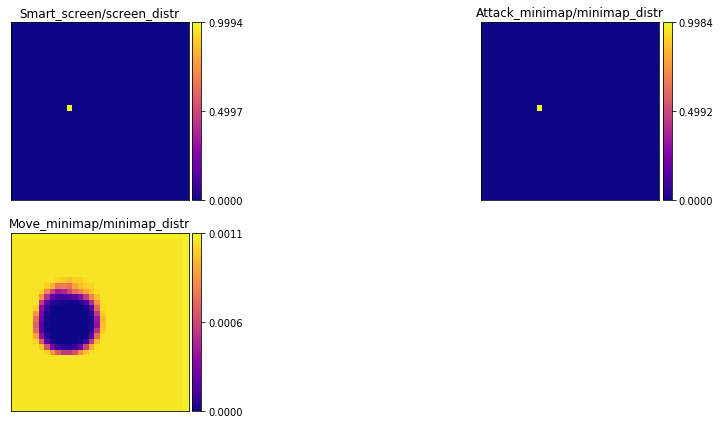


Step 23
Action Smart_screen - prob : 0.882
Action Attack_minimap - prob : 0.118
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


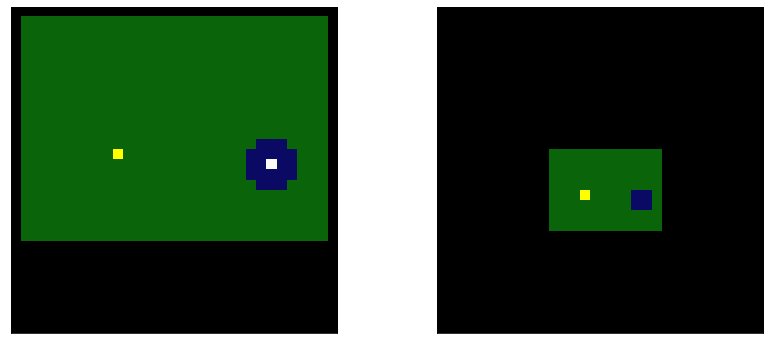

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


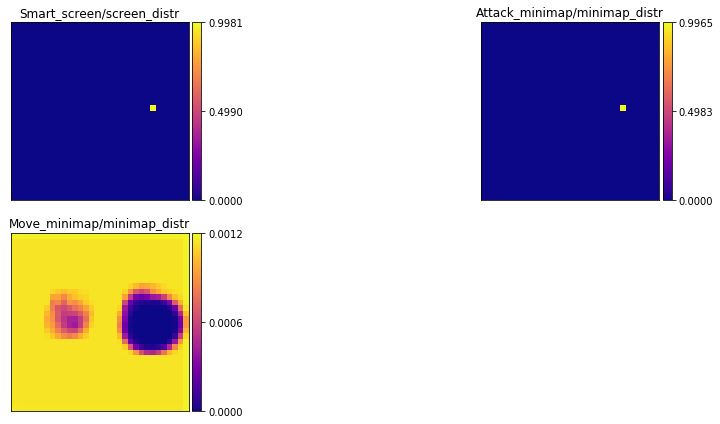


Step 24
Action Smart_screen - prob : 0.884
Action Attack_minimap - prob : 0.116
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Attack_minimap


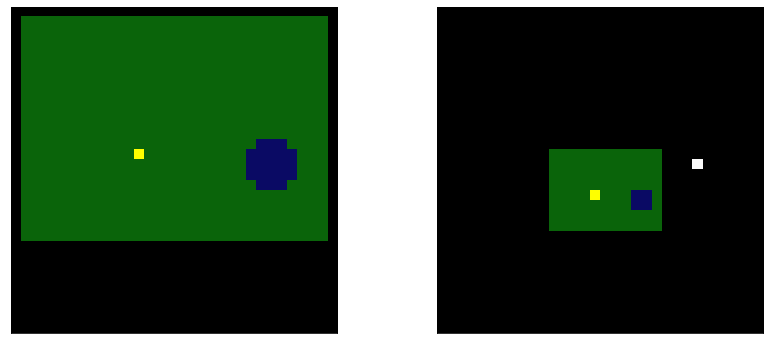

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


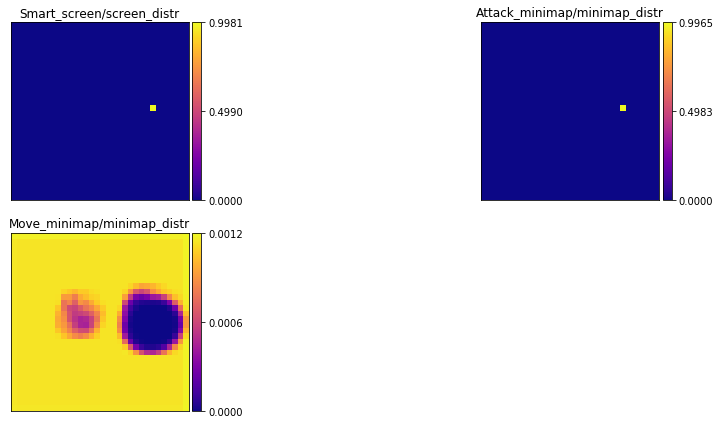


Step 25
Action Smart_screen - prob : 0.884
Action Attack_minimap - prob : 0.116
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


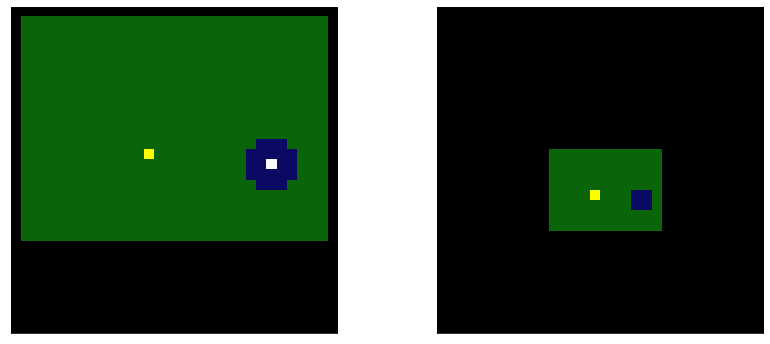

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


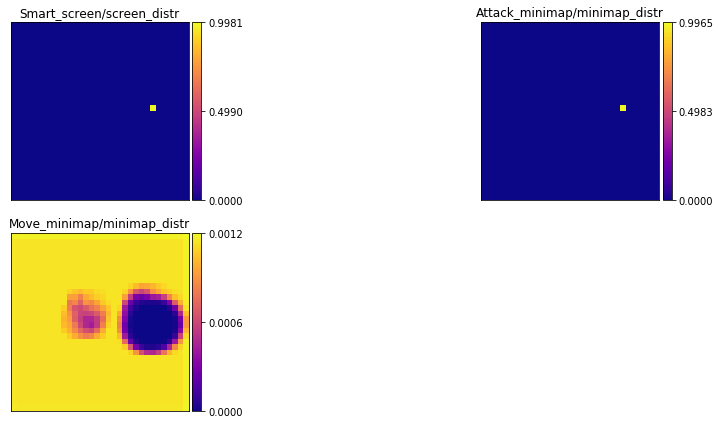


Step 26
Action Smart_screen - prob : 0.885
Action Attack_minimap - prob : 0.115
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


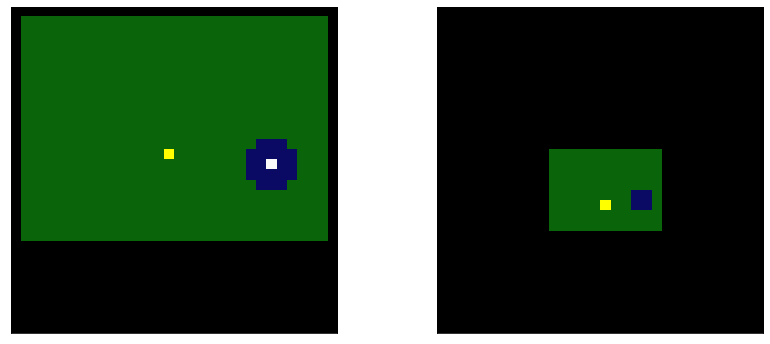

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


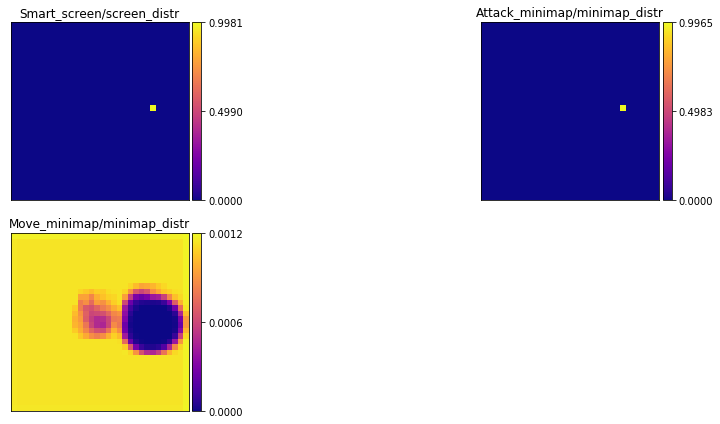


Step 27
Action Smart_screen - prob : 0.886
Action Attack_minimap - prob : 0.114
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


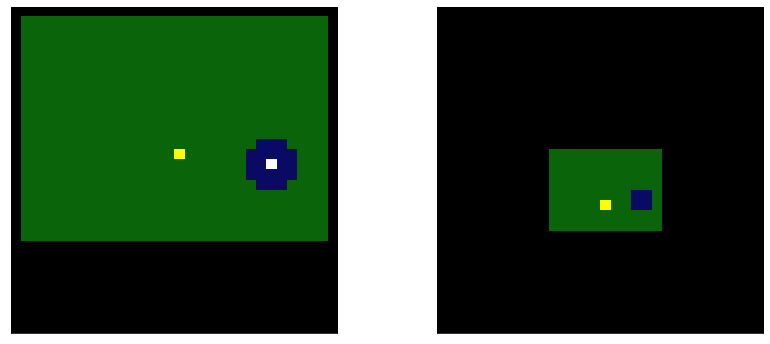

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


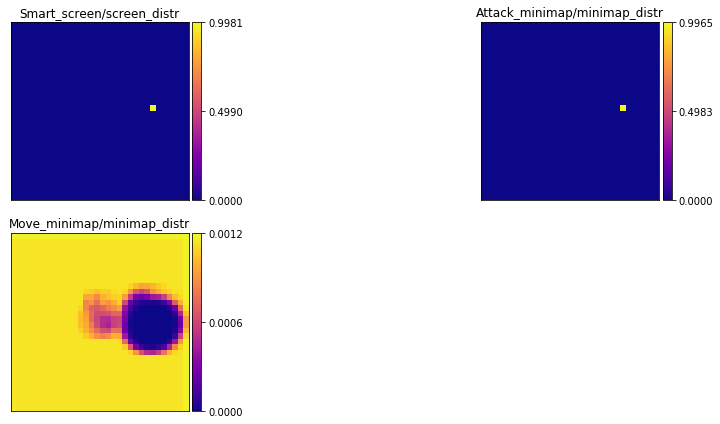


Step 28
Action Smart_screen - prob : 0.888
Action Attack_minimap - prob : 0.111
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


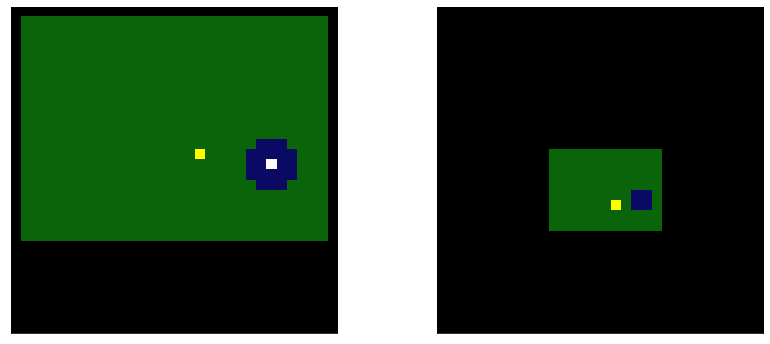

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


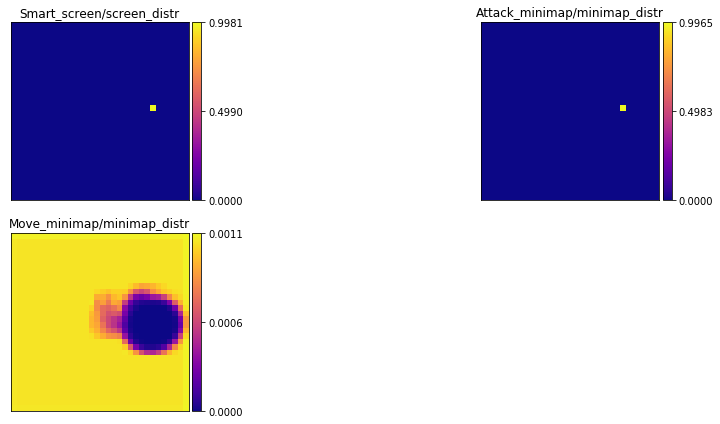


Step 29
Action Smart_screen - prob : 0.889
Action Attack_minimap - prob : 0.111
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


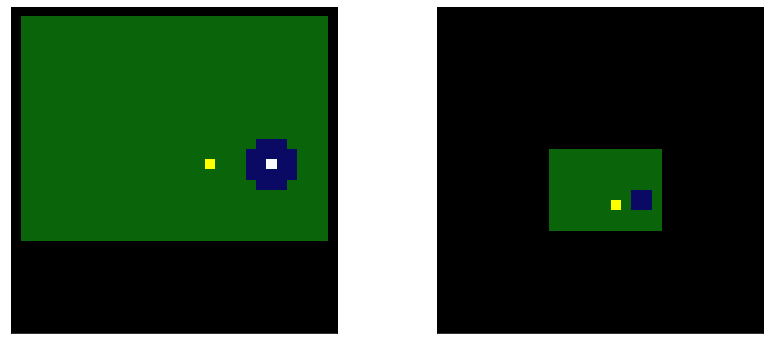

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


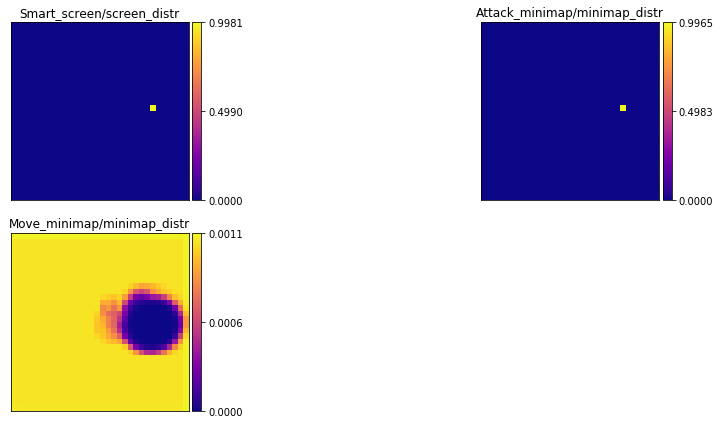


Step 30
Action Smart_screen - prob : 0.891
Action Attack_minimap - prob : 0.108
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


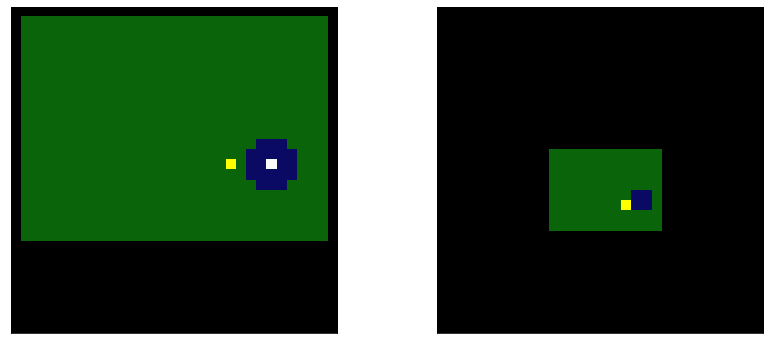

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


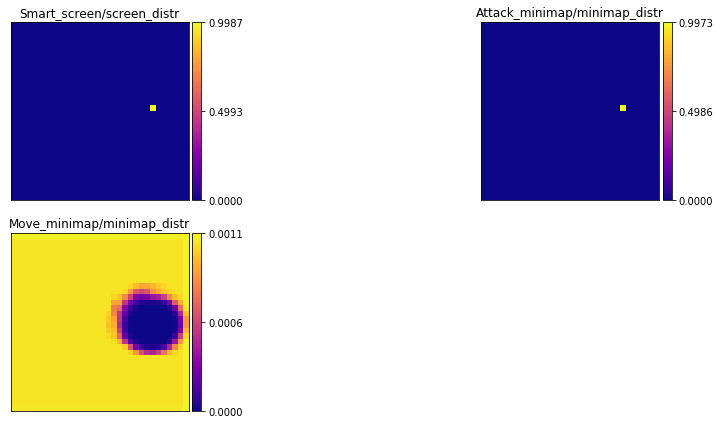


Step 31
Action Smart_screen - prob : 0.894
Action Attack_minimap - prob : 0.105
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


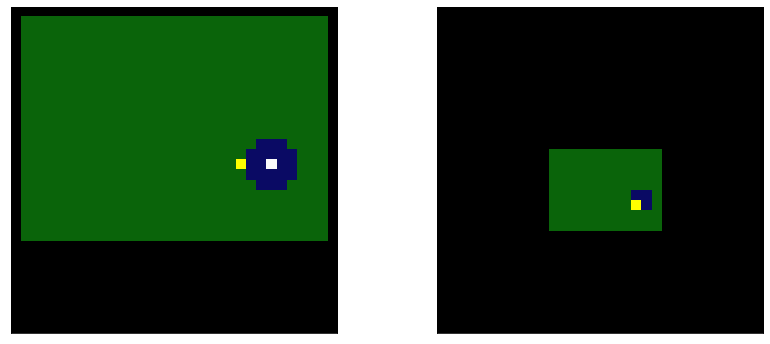

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


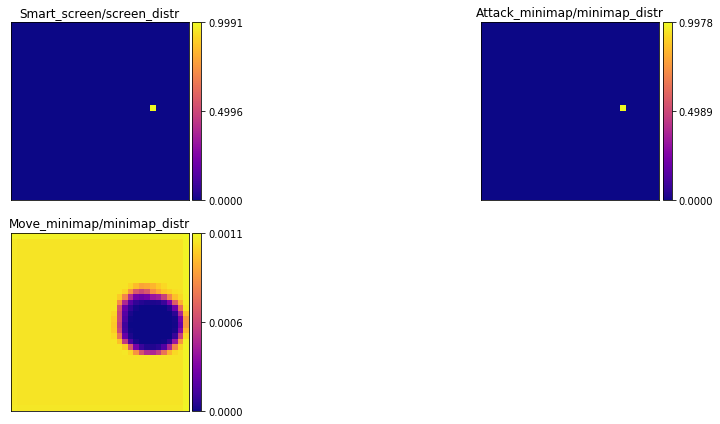


Step 32
Action Smart_screen - prob : 0.874
Action Attack_minimap - prob : 0.125
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


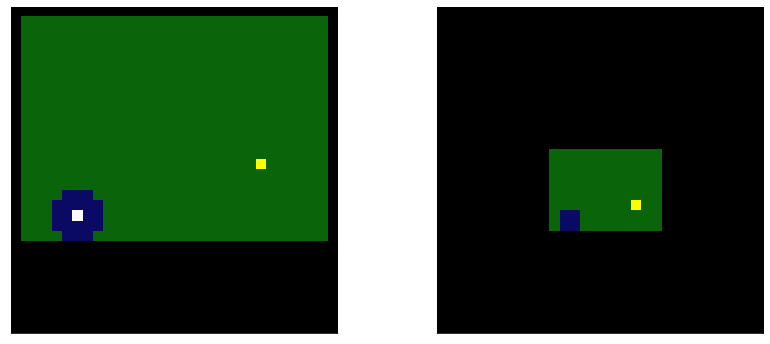

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


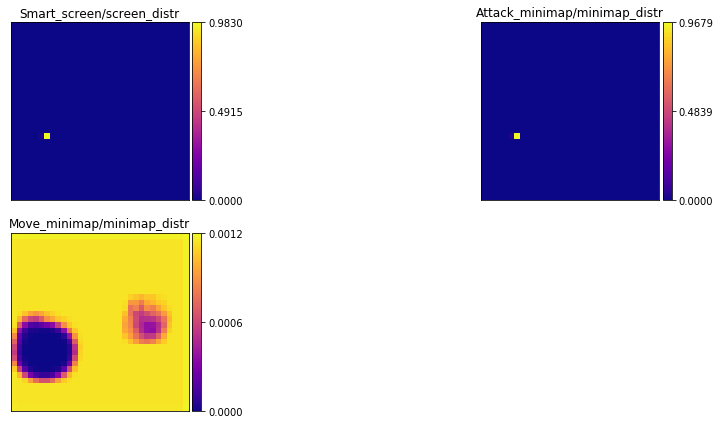


Step 33
Action Smart_screen - prob : 0.876
Action Attack_minimap - prob : 0.123
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


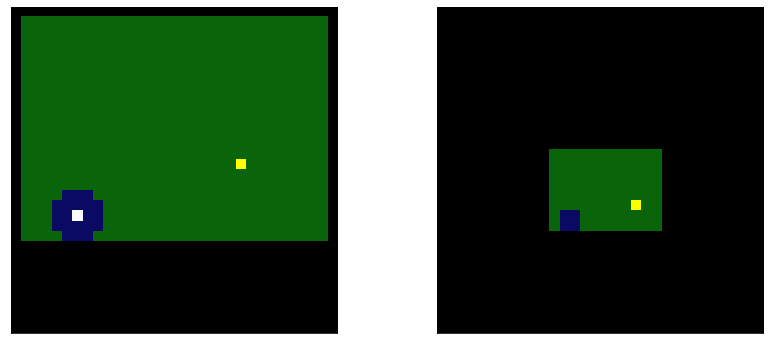

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


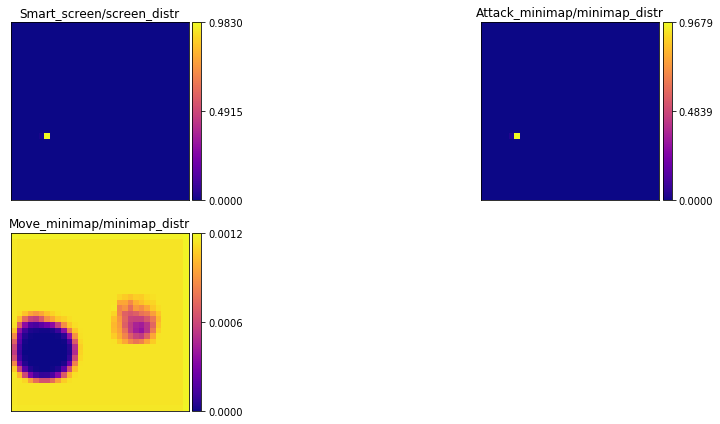


Step 34
Action Smart_screen - prob : 0.876
Action Attack_minimap - prob : 0.123
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


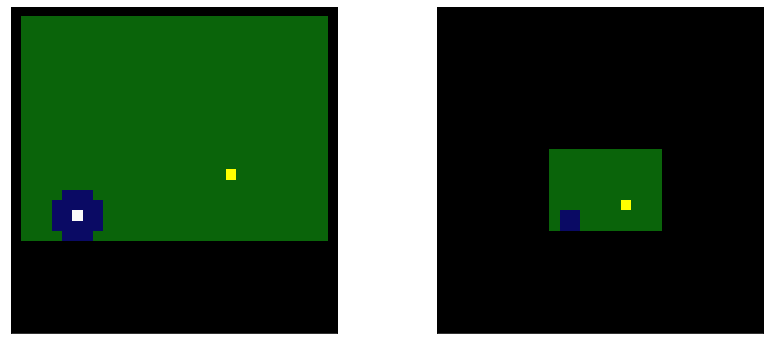

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


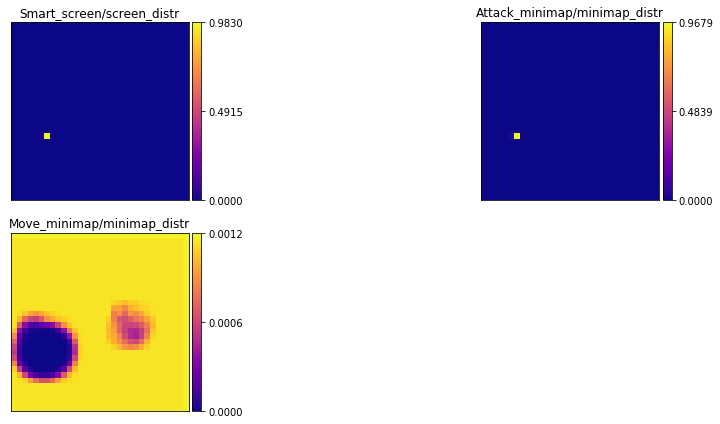


Step 35
Action Smart_screen - prob : 0.879
Action Attack_minimap - prob : 0.120
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


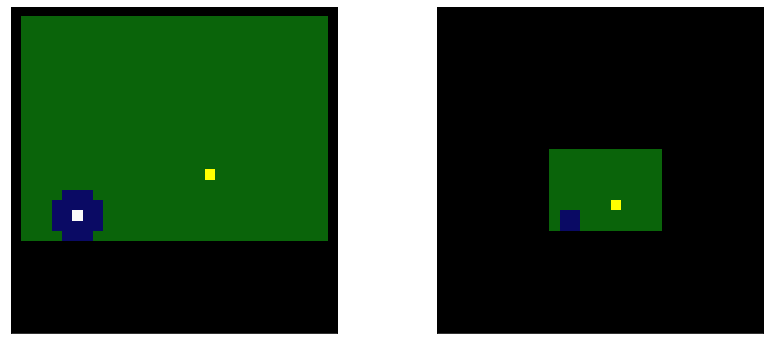

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


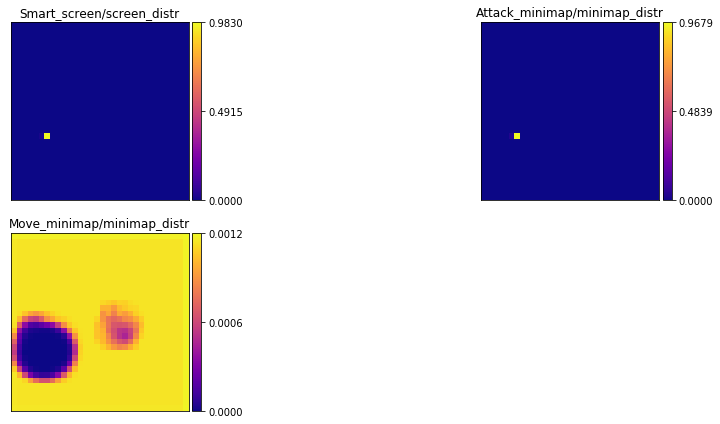


Step 36
Action Smart_screen - prob : 0.881
Action Attack_minimap - prob : 0.118
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


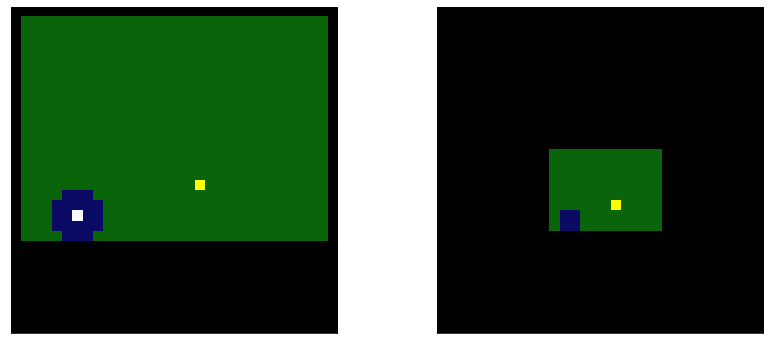

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


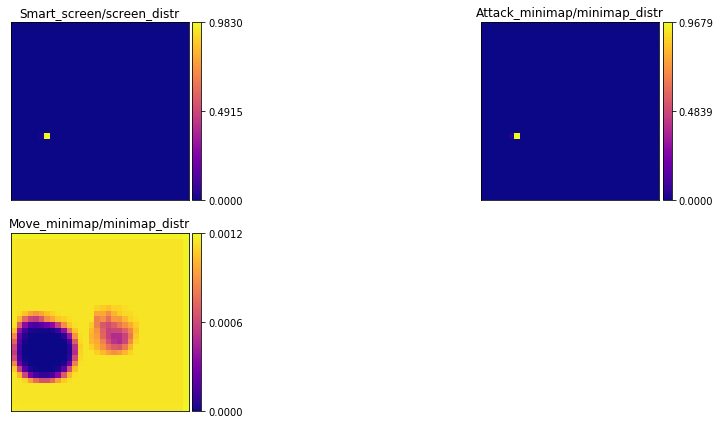


Step 37
Action Smart_screen - prob : 0.882
Action Attack_minimap - prob : 0.117
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


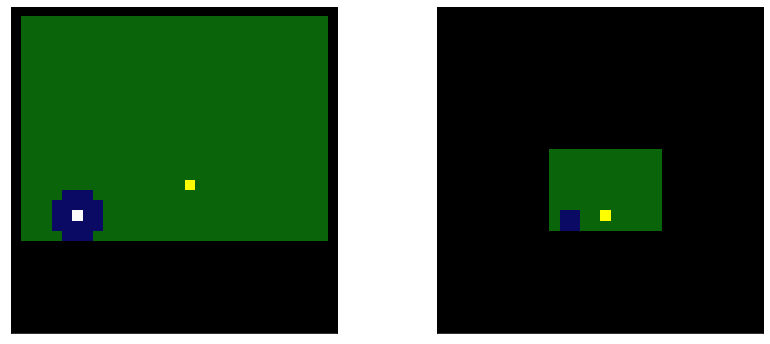

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


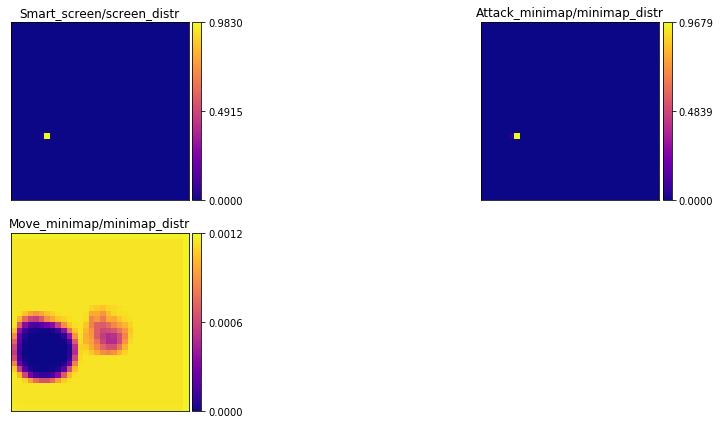


Step 38
Action Smart_screen - prob : 0.884
Action Attack_minimap - prob : 0.116
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


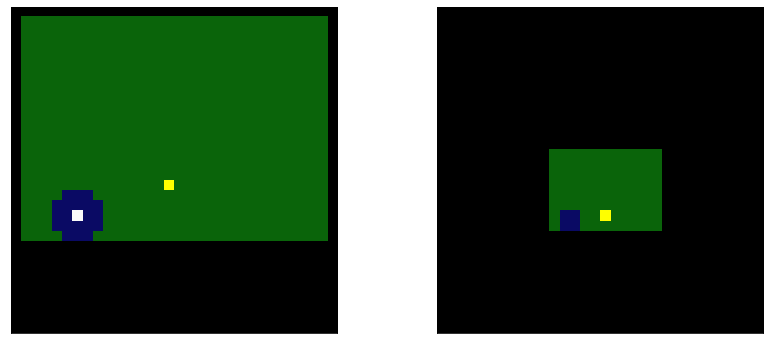

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


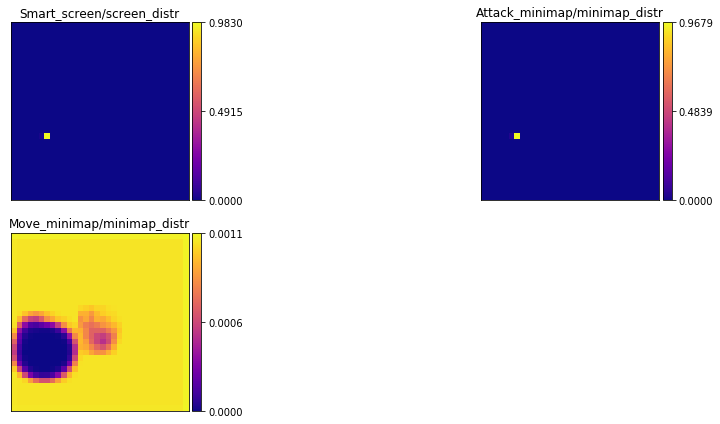


Step 39
Action Smart_screen - prob : 0.885
Action Attack_minimap - prob : 0.115
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Attack_minimap


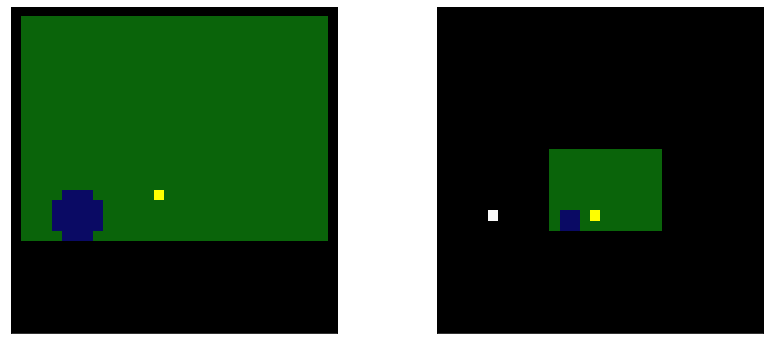

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


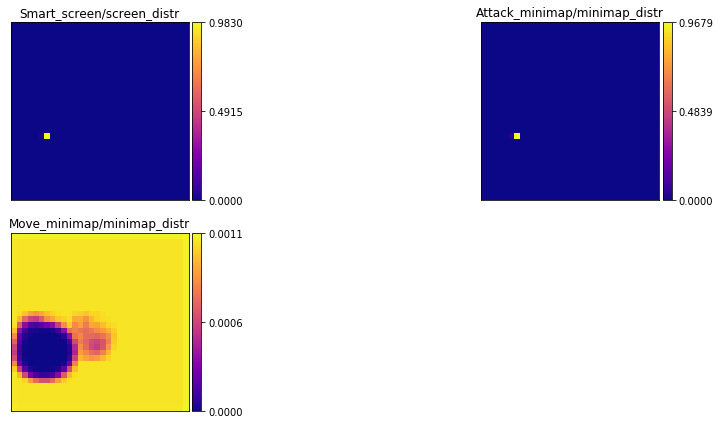


Step 40
Action Smart_screen - prob : 0.887
Action Attack_minimap - prob : 0.112
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


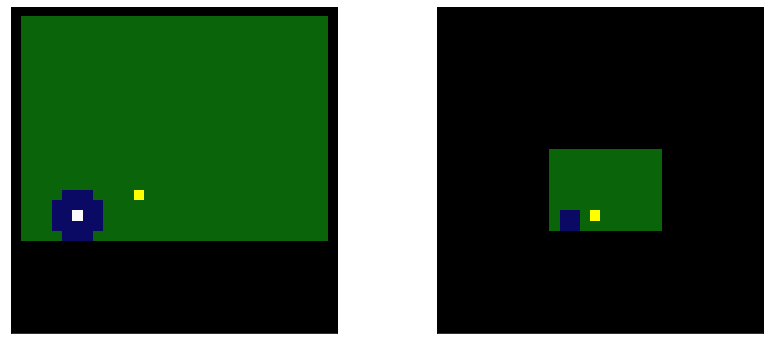

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


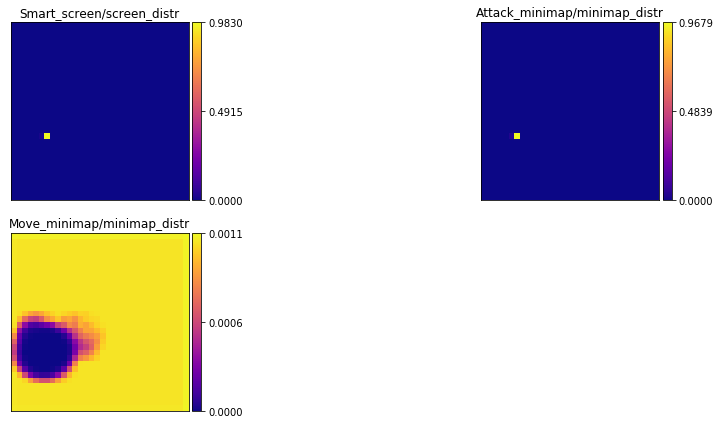


Step 41
Action Smart_screen - prob : 0.890
Action Attack_minimap - prob : 0.110
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


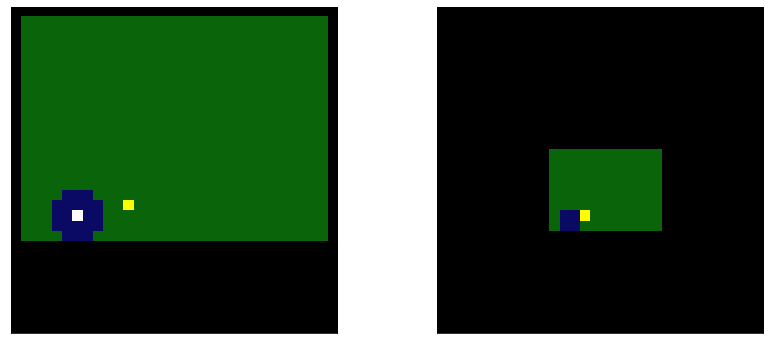

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


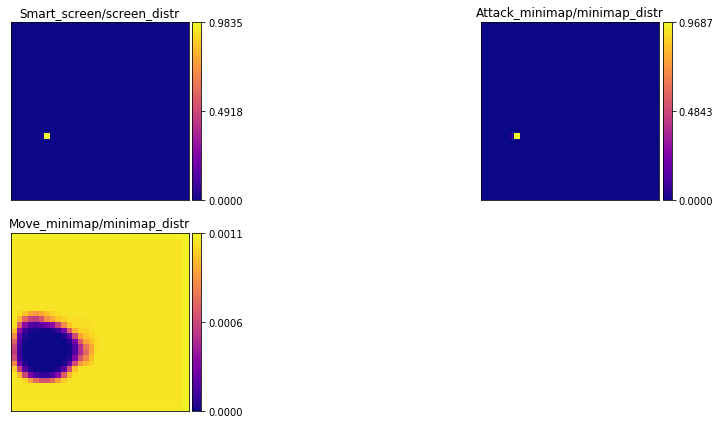


Step 42
Action Smart_screen - prob : 0.892
Action Attack_minimap - prob : 0.108
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


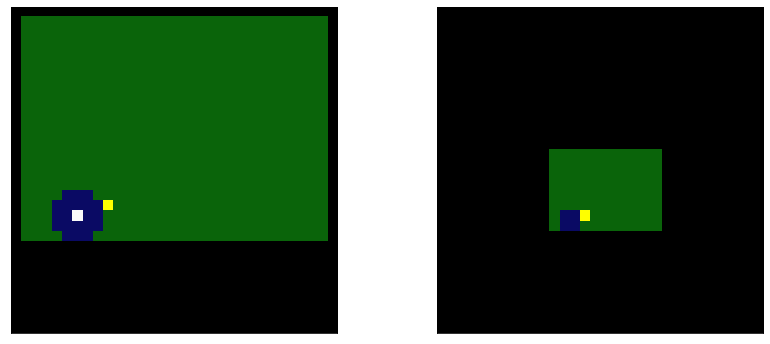

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


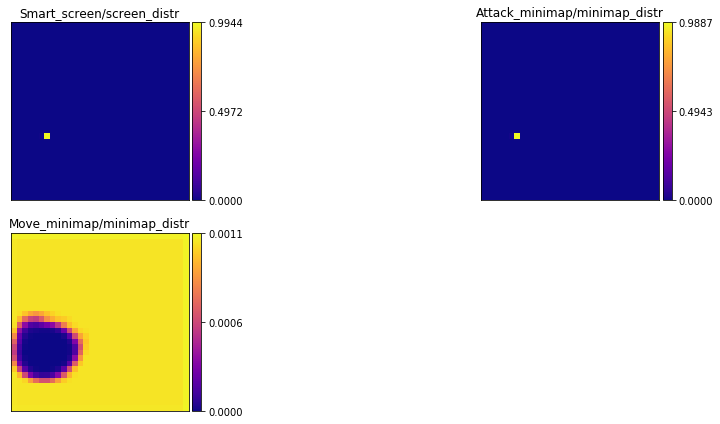


Step 43
Action Smart_screen - prob : 0.892
Action Attack_minimap - prob : 0.107
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


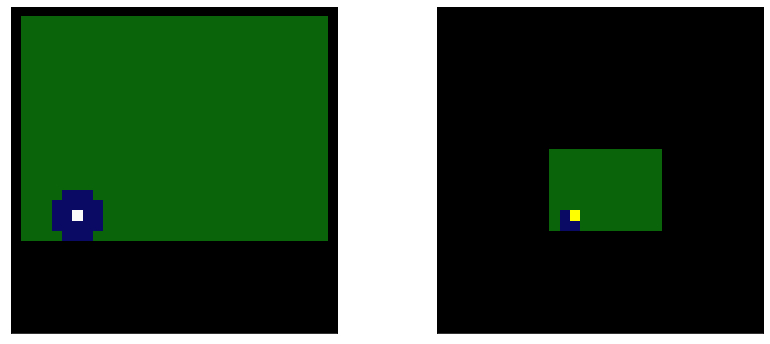

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


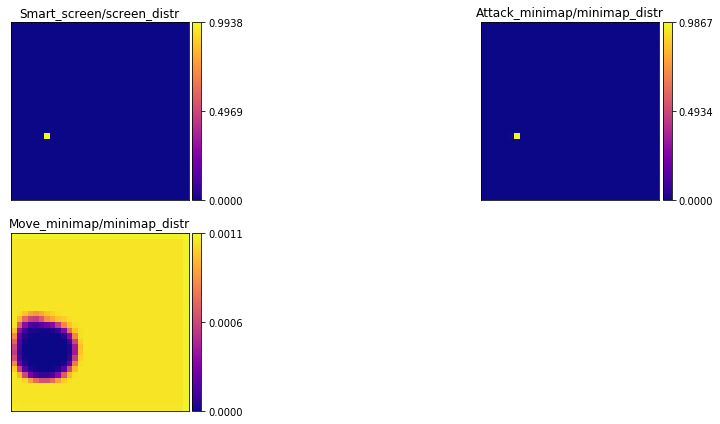


Step 44
Action Smart_screen - prob : 0.880
Action Attack_minimap - prob : 0.119
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


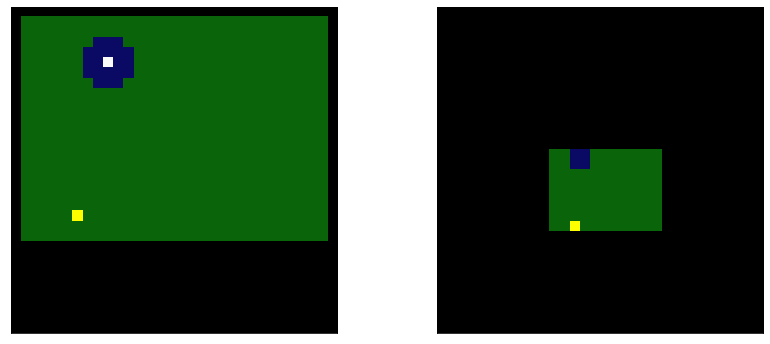

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


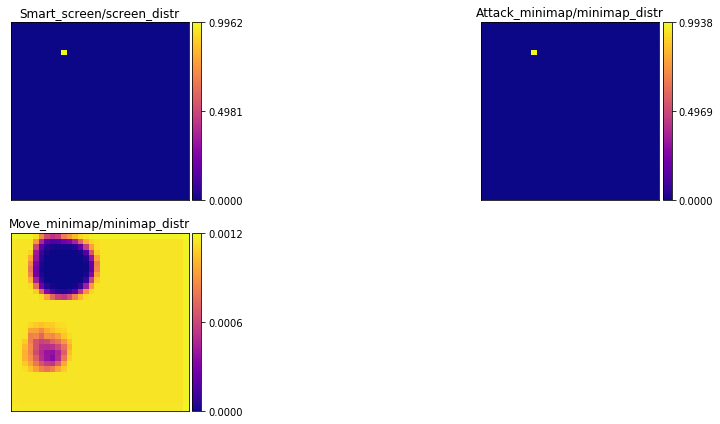


Step 45
Action Smart_screen - prob : 0.881
Action Attack_minimap - prob : 0.119
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


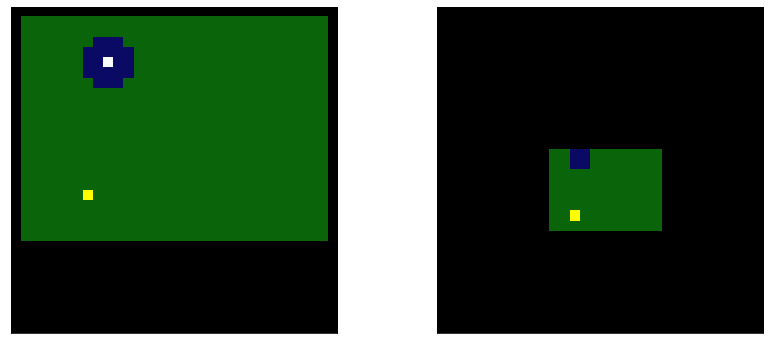

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


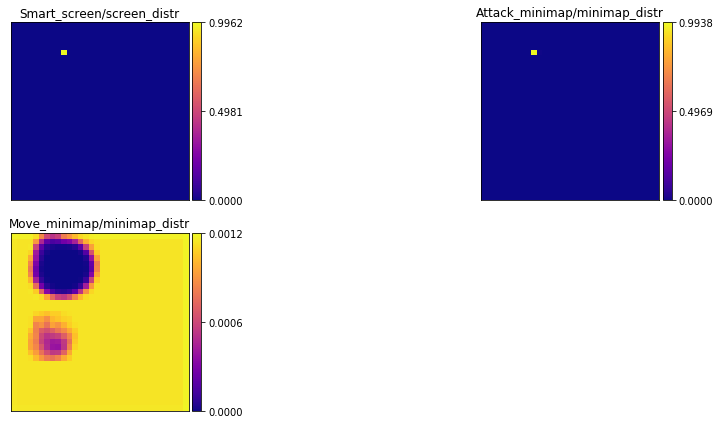


Step 46
Action Smart_screen - prob : 0.880
Action Attack_minimap - prob : 0.119
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


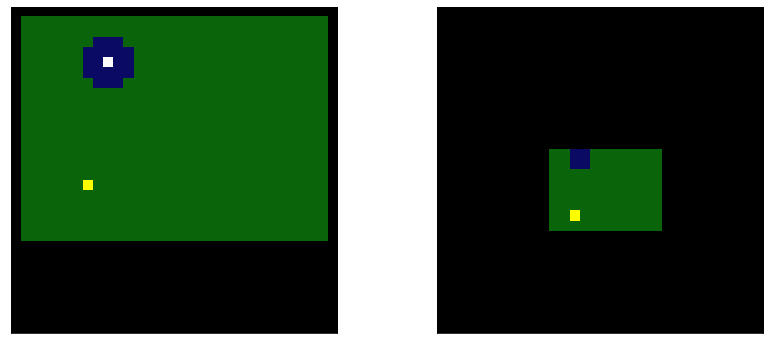

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


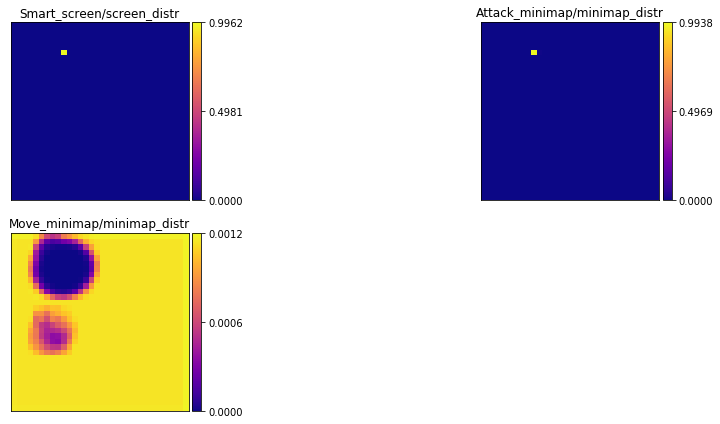


Step 47
Action Smart_screen - prob : 0.883
Action Attack_minimap - prob : 0.117
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


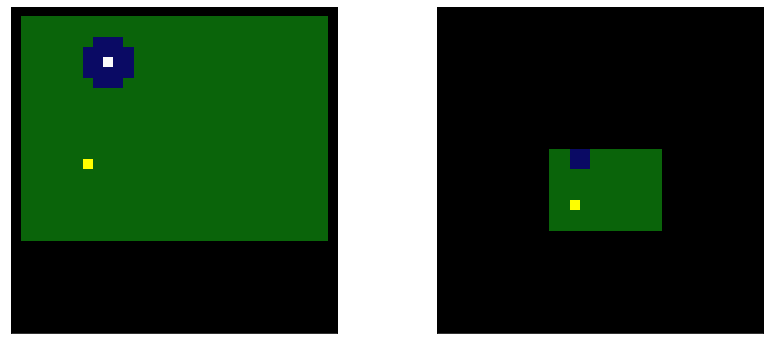

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


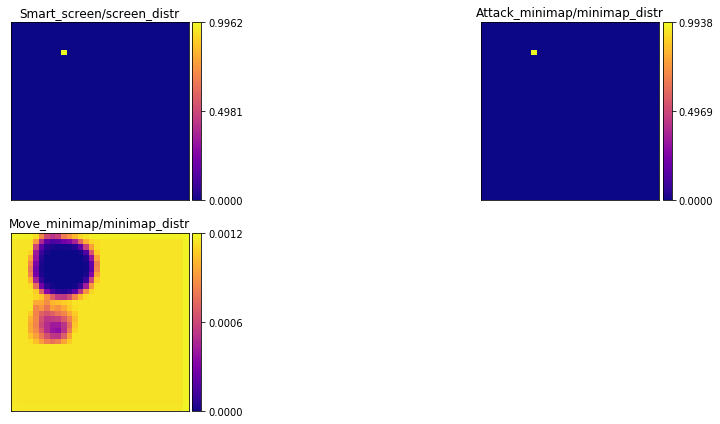


Step 48
Action Smart_screen - prob : 0.886
Action Attack_minimap - prob : 0.113
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


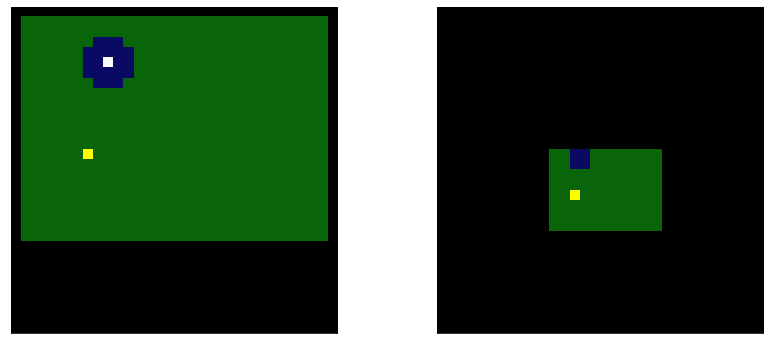

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


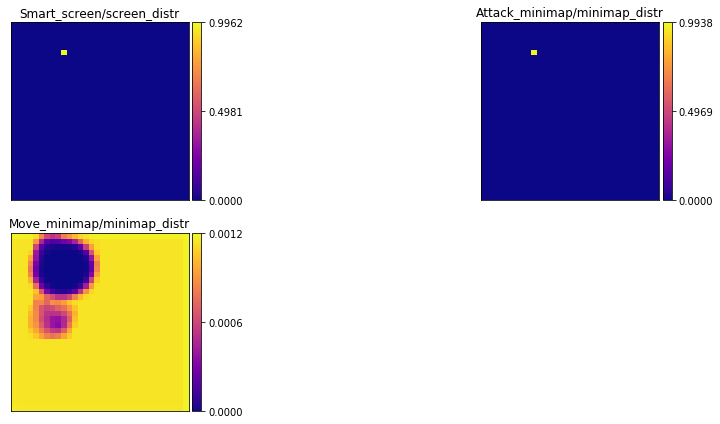


Step 49
Action Smart_screen - prob : 0.892
Action Attack_minimap - prob : 0.107
Action Move_minimap - prob : 0.000
Action select_army - prob : 0.000
Action Stop_quick - prob : 0.000
-----------------------------------
Action chosen:  Smart_screen


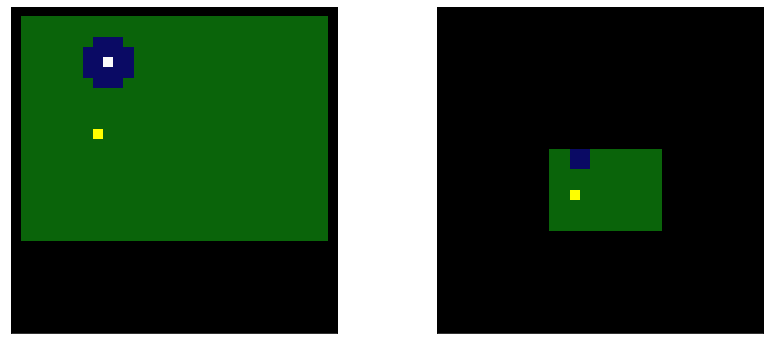

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['Move_minimap/queued_distr', 'Move_minimap/minimap_distr']
['select_army/select_add_distr']
['Stop_quick/queued_distr']


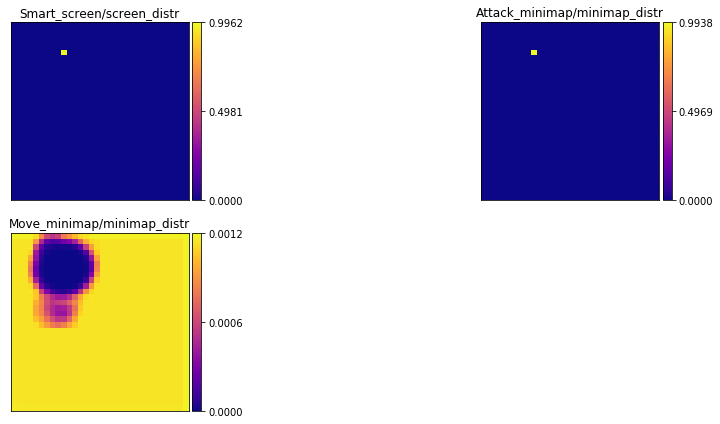

In [23]:
#for t in range(len(insp_dict['state_traj'])):
for t in range(50):
    print_action_info(inspector, insp_dict, t)
    plot_screen_and_decision(inspector, insp_dict, layer_names, t)
    #plot_screen_layers(insp_dict, layer_names, t)
    #plot_minimap_layers(insp_dict, layer_names, t)

In [ ]:
d = insp_dict

In [ ]:
current_state = d['state_traj'][t]['spatial'][0]
current_state.shape

In [16]:
a = d['action_sel'][t][0]
a

451

In [18]:
arg_names = inspector.act_to_arg_names[a]
arg_names

['Smart_screen/queued', 'Smart_screen/screen']

In [21]:
real_arg_names = [arg.split('/')[1] for arg in arg_names]
real_arg_names

['queued', 'screen']

In [26]:
click = None
if 'screen' in real_arg_names:
    args = d['args'][t][0]
    for arg in args:
        if len(arg) == 2:
            click = arg
            break
        else:
            continue
print(click)

[25, 18]


In [ ]:
def plot_screen_distr(d, t, alpha=0.7):
    spatial_args = get_spatial_args(d)
    num_spatial_args = len(spatial_args)
    grid = (2, math.ceil(num_spatial_args/2))
    gs1 = gridspec.GridSpec(*grid)
    
    for i in range(num_spatial_args):
        ax1 = plt.subplot(gs1[i])
        ax1.set_title(spatial_args[i])
        probs = np.exp(d[spatial_args[i]][t])
        _plot_screen_distr(probs)
        plt.axis('on')

    plt.tight_layout()

In [31]:
d['top_5_action_distr'][t].keys()

dict_keys([451, 453, 13, 7, 2])

In [33]:
list(d['top_5_action_distr'][t][451].keys())

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']

In [30]:
actions = d['top_5_actions'][t]
actions

array([451, 453,  13,   7,   2])

In [34]:
spatial_distr = []
spatial_names = []
for a in actions:
    arg_names = list(d['top_5_action_distr'][t][a].keys())
    print(arg_names)
    spatial_arg_names = [name for name in arg_names if ('screen_distr' in name) or ('minimap_distr' in name)]
    for sp_arg in spatial_arg_names:
        spatial_distr.append(d['top_5_action_distr'][t][a][sp_arg])
        spatial_names.append(sp_arg)
        
spatial_names

['Smart_screen/queued_distr', 'Smart_screen/screen_distr']
['Stop_quick/queued_distr']
['Attack_minimap/queued_distr', 'Attack_minimap/minimap_distr']
['select_army/select_add_distr']
['select_point/select_point_act_distr', 'select_point/screen_distr']


['Smart_screen/screen_distr',
 'Attack_minimap/minimap_distr',
 'select_point/screen_distr']